## Подготовка

Импортируем все необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import sklearn
import time

#загружаем библиотеку для проверки корректности url ссылки
import requests
#загружаем библиотеку для корректной загрузки датасетов
import os

#загружаем библиотеку для корреляционного анализа
import phik

#загружаем классы для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функции для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

#загружаем инструменты для подбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#загружаем библиотеку и класс для просчитывания важности признаков
from sklearn.inspection import permutation_importance
import shap

## Первый этап работы: исследование уровня удовлетворённости сотрудников

### Загрузка и изучение данных

Загружаем файлы датасетов, создаем датафреймы, выводим первые 15 строк и основную информацию о них для ознакомления. Значение параметра `index_col сразу` не задаем, так как нет уверенности в том, что в данных нет дубликатов

In [4]:
#проверяем существование указанной дирректории и в случае возврата True загружаем датасеты в переменные, указав верные разделители
pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth2 = 'https://.../datasets/train_job_satisfaction_rate.csv' #часть ссылки скрыта ввиду NDA
pth3 = 'train_job_satisfaction_rate.csv'
if os.path.exists(pth1):
    data_train_rate = pd.read_csv(pth1, sep=',', decimal = '.')
    data_x_test = pd.read_csv('/datasets/test_features.csv', sep=',', decimal = '.')
    data_y_test_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal = '.')
#добавляем проверку корректности url ссылки при помощи requests.get(url) и проверки status_code == 200
elif requests.get(pth2).status_code == 200:
    data_train_rate = pd.read_csv(pth2, sep=',', decimal = '.')
    data_x_test = pd.read_csv('https://.../datasets/test_features.csv', sep=',', decimal = '.') #часть ссылки скрыта ввиду NDA
    data_y_test_rate = pd.read_csv('https://.../datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal = '.') #часть ссылки скрыта ввиду NDA
elif os.path.exists(pth3):
    data_train_rate = pd.read_csv(pth3, sep=',', decimal = '.')
    data_x_test = pd.read_csv('test_features.csv', sep=',', decimal = '.')
    data_y_test_rate = pd.read_csv('test_target_job_satisfaction_rate.csv', sep=',', decimal = '.')
else:
    print('Something is wrong')


#выводим первые 15 строк и основную информацию для каждого датафрейма    
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    display(d.head(15))
    d.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Созданные датафреймы:**
- имеют следующие размерности:
    - data_train_rate - 4000 строк;
    - data_x_test - 2000 строк;
    - data_y_test_rate - 2000 строк;
- имеют явные пропуски
- столбцы имеют корректные типы данных
- названия столбцов приведены к змеиному "регистру"
- при первичном ознакомлении неявные дубликаты не выделяются

###  Предобработка данных

#### Переименование столбцов

Так как столбцы приведены к змеиному регистру, то нам остается проверить, что столбцы в `data_train_rate`(без учета столбца с целевым признаком `job_satisfaction_rate`) имеют точно такие же названия столбцов и порядок, что и в `data_x_test`. При прогнозировании очень важно передать в модель тот же самый порядок и наименования столбов, что использовались при обучении.

In [5]:
data_train_rate.columns.tolist()[:-1] == data_x_test.columns.tolist()

True

Названия полностью совпали. Остается проверить, чтобы не было лишних пробелов в названиях столбцов

In [6]:
for d in data_train_rate,data_x_test,data_y_test_rate:
    print(d.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
['id', 'job_satisfaction_rate']


Лишних пробелов нет

**Столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.**

#### Проверка пропусков

Посчитаем все явные пропуски во всех датафреймах:

In [7]:
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    print(d.isna().sum().sort_values(ascending = False))

dept                     6
level                    4
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
dept                     2
level                    1
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id                       0
job_satisfaction_rate    0
dtype: int64


**Столбцы с должностью `dept` и уровнем квалификации `level` имеют явные пропуски в тренировочном и тестовом датафреймах.** Найденные пропуски заполним в пайплайне, поэтому оставим найденные пропуски в категориальных столбцах как есть и при построении модели учтем это и добавим при кодировании обработку пропусков при помощи SimpleImputer().

#### Аномальные значения

Выведем описательные статистики для всех количественных столбцов

In [8]:
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    display(round(d.describe().T,2))

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.62,257883.10,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.72,2.54,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.48,1.01,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.70,14900.70,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.53,0.23,0.03,0.36,0.56,0.71,1.0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.67,2.54,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.53,1.00,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.80,15398.44,12000.0,22800.0,30000.0,43200.00,96000.0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.55,0.22,0.03,0.38,0.58,0.72,1.0


**При первичном ознакомлении со статистиками явных аномалий не наблюдается. При дальнейшем исследовательском анализе посмотрим распределения величин для поиска выбросов и еще раз аномальных значений.**

**В рассматриваемых датасетах отсутствуют аномальные значения**

#### Изменение типов данных столбцов

Проверим типы данных всех столбцов всех датафреймов:

In [9]:
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 -------------- 

**Типы данных столбцов соответствуют значениям в них**

#### Обработка дубликатов

Проверим датафреймы на наличие явных дубликатов

In [10]:
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    print(d.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено. Теперь проверим датафреймы на наличие неявных дубликатов. Сначала проверим все уникальные значения в категориальных столбцах

In [11]:
for d in [data_train_rate,data_x_test,data_y_test_rate]:
    for c in d.select_dtypes(include='object').columns.tolist():
        print(f'Значение столбца {c}: {d[c].unique()}')

Значение столбца dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Значение столбца level: ['junior' 'middle' 'sinior' nan]
Значение столбца workload: ['medium' 'high' 'low']
Значение столбца last_year_promo: ['no' 'yes']
Значение столбца last_year_violations: ['no' 'yes']
Значение столбца dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Значение столбца level: ['junior' 'middle' 'sinior' nan]
Значение столбца workload: ['medium' 'low' 'high' ' ']
Значение столбца last_year_promo: ['no' 'yes']
Значение столбца last_year_violations: ['no' 'yes']


*Неявных дубликатов не обнаружено. Из результата видно, что помимо явных пропусков в столбцах `dept` и `level` тестового датафрейма также есть неявные пропуски в столбцах `dept` и `workload`. Посмотрим кол-во таких значений*

In [12]:
data_x_test[(data_x_test['dept'] == ' ') | (data_x_test['workload'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Эти пропуски будут обработаны в пайплайне. Также из результата уникальных значений видно, что есть некоректное значение `sinior`, поменяем на корректное `senior`

In [13]:
for d in data_train_rate, data_x_test:
    d['level'] = d['level'].replace('sinior','senior')
    print(d['level'].unique())

['junior' 'middle' 'senior' nan]
['junior' 'middle' 'senior' nan]


Теперь проверим, чтобы не было повторяющихся значений в столбце `id` во всех датафреймах:

In [14]:
for d in  data_train_rate,data_x_test,data_y_test_rate:
    print(f"Кол-во дубликатов: {d['id'].duplicated().sum()}")

Кол-во дубликатов: 0
Кол-во дубликатов: 0
Кол-во дубликатов: 0


Неявных дубликатов в столбцах с `id` нет. Других критериев кроме `id` для уникальной идентификации сотрудников не задать условиями, поэтому делаем вывод, что явных и неявных дубликатов нет.

**Во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test`, которые будут обработаны в пайплайне во время кодирования значений**

**На этапе предобработки данных были выполнены следующие действия:**
- столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.
- столбцы с должностью `dept` и уровнем квалификации `level` имеют явные пропуски в тренировочном и тестовом датафреймах. Найденные пропуски в категориальных столбцах при обучении модели будут обработаны в пайплайне, добавим при кодировании обработку пропусков.
- явных аномальных значений в данных не обнаружено.
- типы данных столбцов соответствуют значениям в них
- во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test`, которые также будут обработаны в пайплайне во время кодирования значений.

### Исследовательский анализ

Выведем все описательные статистики снова для признаков c указанием имен датафреймов

In [15]:
#создадим словарь с нашими датафреймами, чтобы можно было выводить удобно их названия
dataframes = {
    'data_train_rate': data_train_rate,
    'data_x_test': data_x_test,
    'data_y_test_rate': data_y_test_rate,
}
for name, d in dataframes.items():
    print(f'Описательные статистики для {name}')
    display(round(d.describe(),2).T)

Описательные статистики для data_train_rate


,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.62,257883.10,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.72,2.54,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.48,1.01,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.70,14900.70,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.53,0.23,0.03,0.36,0.56,0.71,1.0


Описательные статистики для data_x_test


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.67,2.54,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.53,1.00,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.80,15398.44,12000.0,22800.0,30000.0,43200.00,96000.0


Описательные статистики для data_y_test_rate


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.55,0.22,0.03,0.38,0.58,0.72,1.0


- минимальные и максимальные значения, медианные значения и значения каждого квартиля у идентичных по наименованию столбцов тренировочной и тестовой выборки практически одинаковые по всем столбцам при сравнении, обучившись на тренировочных данных, модель должна иметь небольшой разброс при прогнозе
- медианное значение удовлетворенности сотрудников на тренировочной выборке составляет 0.56, на тестовой немного выше 0.58.

Теперь посмотрим сколько минимально и максимально строчек с каждым уникальным значением есть в целевом признаке

In [17]:
pd.concat([data_train_rate.job_satisfaction_rate.value_counts().head(5),\
           data_train_rate.job_satisfaction_rate.value_counts().tail(5)])

0.65    94
0.67    90
0.68    85
0.69    84
0.66    81
0.94     4
0.04     4
0.98     3
0.03     3
1.00     2
Name: job_satisfaction_rate, dtype: int64

Построим поочередно графики для всех признаков. Сначала построим графики распределения количественных признаков 
для всех датафреймов с разными графиками для дискретных и непрерывных величин. Так как количество строк  в тренировочном датафрейме в 2 раза больше, чем в тестовом, то накладывать графики друг на друга особого смысла нет, так как частота встречаемости в первом разе будет намного выше, расположим графики рядом друг с другом

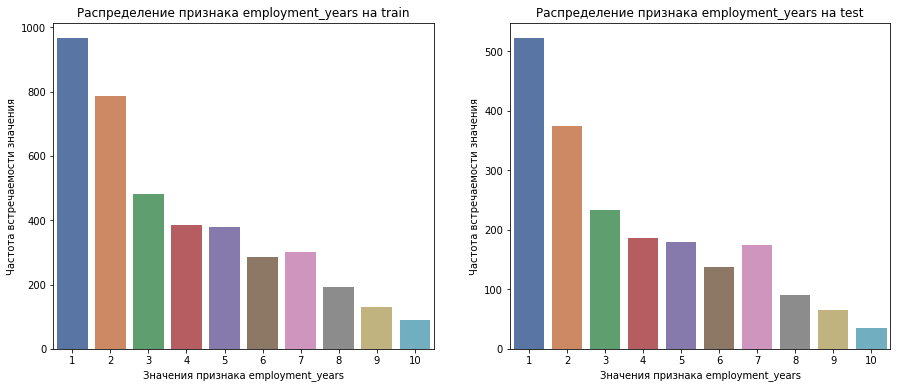

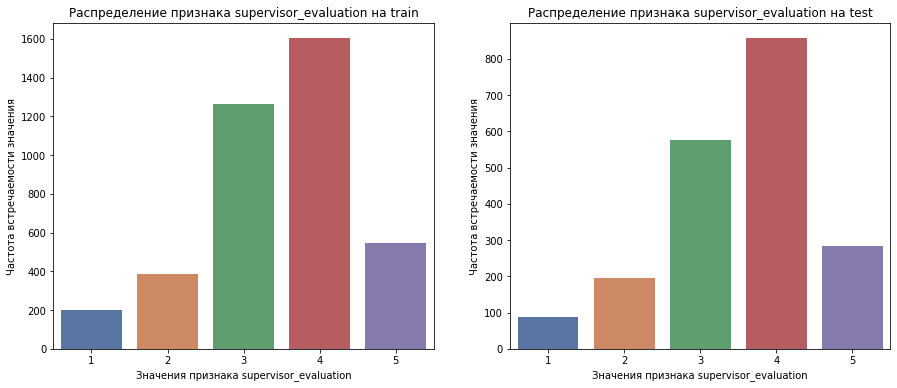

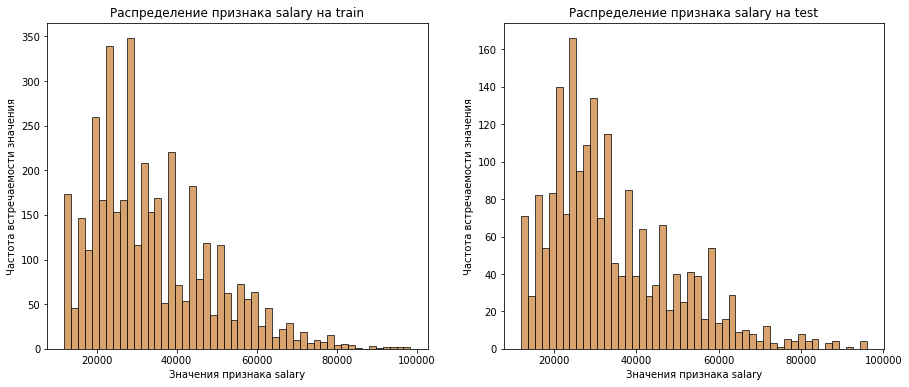

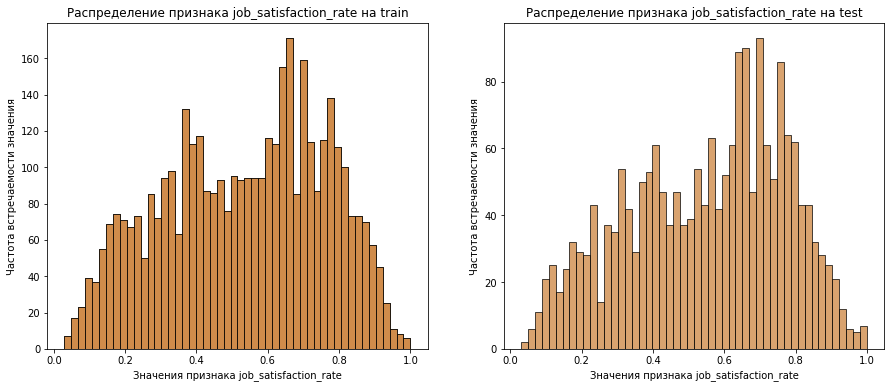

In [18]:
for c in data_train_rate.select_dtypes(exclude='object').columns.tolist()[1:]:
    try:
#создаем сразу две фигуры в линию и оси к ней, подписываем оси и наименование графиков
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
        axes[0].set_title(f'Распределение признака {c} на train')
        axes[0].set_xlabel(f'Значения признака {c}')
        axes[0].set_ylabel('Частота встречаемости значения')
        
        axes[1].set_title(f'Распределение признака {c} на test')
        axes[1].set_xlabel(f'Значения признака {c}')
        axes[1].set_ylabel('Частота встречаемости значения')
#условие для построения графиков для дискретных значений (целочисленные и меньше 30 в наборе уникальных значений) 
        if (data_train_rate[c].dtype == 'int64') and (len(data_train_rate[c].unique()) < 30):
            sns.countplot(data = data_train_rate, x=c, palette = 'deep',ax=axes[0])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[0].set_xlabel(f'Значения признака {c}')
            axes[0].set_ylabel('Частота встречаемости значения')
            sns.countplot(data = data_x_test, x=c, palette = 'deep',ax=axes[1])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[1].set_xlabel(f'Значения признака {c}')
            axes[1].set_ylabel('Частота встречаемости значения')
            plt.show()
#оставшиеся значения (с плавающей точкой или целочисленные, но в наборе больше 30 значений)
        else:
            sns.histplot(data = data_train_rate, x = c, color = 'peru', bins = 50,ax=axes[0])
            sns.histplot(data = data_x_test, x = c, color = 'peru', bins = 50,ax=axes[1])
            plt.show()
# для построения графика для оценки удовлетворенности, вынесен отдельно, так как он в другом датафрейме
    except:
        sns.histplot(data = data_train_rate, x = c, color = 'peru', bins = 50,ax=axes[0])
        sns.histplot(data = data_y_test_rate, x = c, color = 'peru', bins = 50,ax=axes[1])
        plt.show()

Теперь посмотрим на распределение категориальных признаков датафреймов

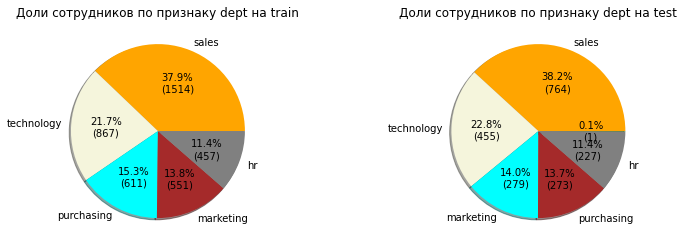

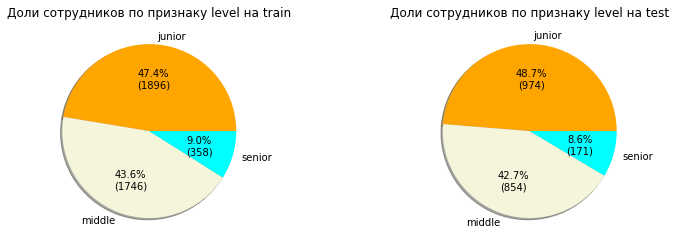

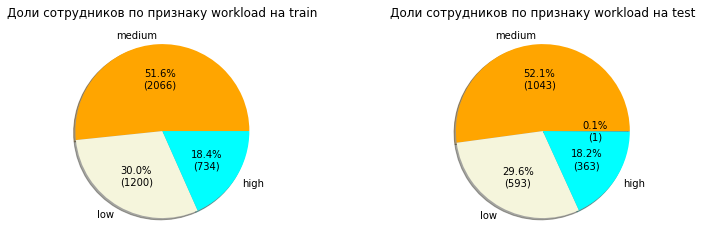

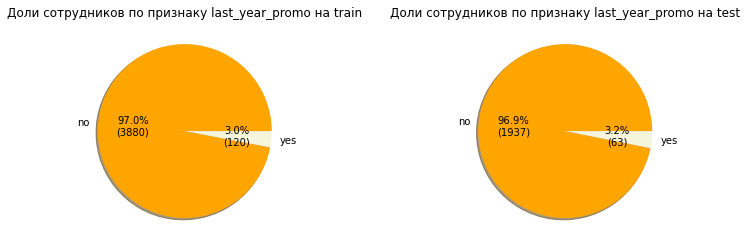

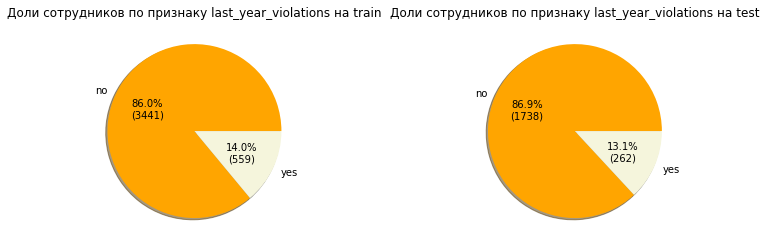

In [19]:
#добавим сразу свой набор цветов для графиков
colors = ("orange", "beige","cyan", "brown","grey", "green")
#создадим список из наименований столбцов со строковыми значениями для использования в цикле
for c in data_train_rate.select_dtypes(include='object').columns.tolist():
#создадим агррегированные таблицы для использования при построении графиков       
    train_pie = data_train_rate.pivot_table(index = c, values = 'id', aggfunc={'count'}).sort_values(by= 'count', ascending = False).reset_index()
    test_pie = data_x_test.pivot_table(index = c, values = 'id', aggfunc={'count'}).sort_values(by= 'count', ascending = False).reset_index()
#строим сразу фигуру для двух графиков рядом, чтобы визуально можно было отследить разные доли между одним признаком 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12.5,4))
#добавляем в autopct вывод еще и количества в каждой доли
    axes[0].pie(train_pie['count'], labels = train_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_train_rate.shape[0]/100)),\
                colors=colors, shadow=True)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].set_title(f'Доли сотрудников по признаку {c} на train')

    axes[1].pie(test_pie['count'], labels = test_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_x_test.shape[0]/100)),\
                colors=colors, shadow=True)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].set_title(f'Доли сотрудников по признаку {c} на test')
#выведем графики
    plt.show()


**Полученные графики для количественных признаков показывают следующее:**
- распределения на тренировочном датасете и на тестовом для количественных признаков очень схожи, соблюдены пропорции каждого из признаков, похоже, что один общий датасет разделили на тренировочный и тестовый, указав в стратификации все признаки
- кол-во отработанных лет имеет диапазон значений от 1 до 10 лет. Самое частое значение - 1 год и частота встречаемости плавно уменьшается к 10 годам
- самые частые оценки руководителя - 4 и 3, значит большинство сотрудников выполяют свои должностные обязанности
- медианное значение зарплаты - 30000, всего 25% сотрудников получают зарплату выше 43200, при корреляции посмотрим  как это влияет на удовлетворенность сотрудников.
- график распределения удовлетворенности сотрудников похож на нормальное распределение со смещением в диапазон 0.7 для самых часто встречающихся значений, медианные же значения находятся в дипазоне 0.56 для тренировочного датасета и 0.58 для тестового датасета

**Полученные графики для категориальных признаков позволяют сделать следующие выводы:**
- распределения долей на тренировочном датасете и на тестовом в категориальных признаках также очень схожи, как и у количественных признаков
- по количеству сотрудников на разных должностях распределений долей в тренировочном и тестовом датафрейме получилось следующим:
  - `sales` - 37.9% на тренировочном и 38.2% на тестовом
  - `technology` - 21.7% на тренировочном и 22.8% на тестовом
  - `purchasing` - 15.3% на тренировочном и 14% на тестовом
  - `marketing` - 13.8% на тренировочном и 13.7% на тестовом
  - `hr` - 11.4% на тренировочном и 11.4% на тестовом
- по уровню квалицикации доли сотрудников распределяются следующим образом:
  - `junior` - 47.4.9% на тренировочном и 48.7% на тестовом
  - `middle` - 43.6% на тренировочном и 42.7% на тестовом
  - `senior` - 9% на тренировочном и 8.6% на тестовом
- по загруженности больше всего средняя оценка загруженности `medium` - 51.6% на тренировочном и 52.1% на тестовом датафрейме
- у подавляющего большинства сотрудников не было повышений за прошлый год - 97% на тренировочном и 96.9% на тестовом датафрейме
- у большинства сотрудников не было выявленных нарушений за прошлый год - 86% на тренировочном и 86.9% на тестовом датафрейме

*Так как в нашем исследовании мы будем использовать несколько моделей, включая линейную, то категориальные признаки мы будем кодировать при помощи нескольких кодировщиков: OneHotEncoder() и OrdinalEncoder(), также так как у нас есть явные и неявные пропуски в категориальных столбцах, то при использовании кодировщиков нужно использовать обработку пропусков и замену их на моды. Количественные признаки имеют разные величины значений, поэтому к ним будем применять масштабирование StandardScaler() и MinMaxScaler() через словарь гиперпараметров.*

### Корреляционный анализ

Проведем корреляционный анализ, чтобы устранить мультиколлинеарность при ее наличии

Построим матрицу корреляции коэффициентов Пирсона для всех количественных признаков для датафрейма `data_train_rate`

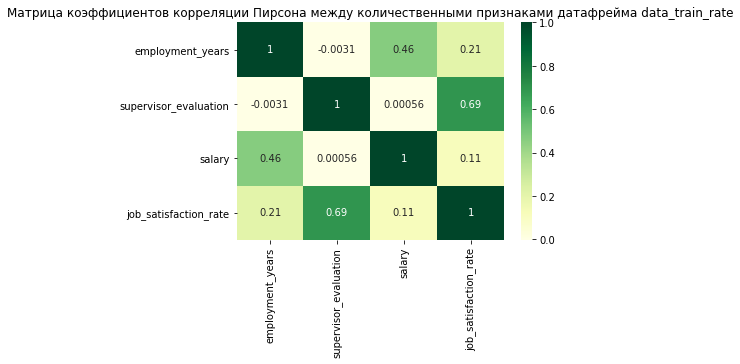

In [20]:
plt.figure(figsize = (6,4))
sns.heatmap(data_train_rate[data_train_rate.select_dtypes(exclude='object').columns.tolist()[1:]].corr(), annot=True, cmap='YlGn')
plt.title('Матрица коэффициентов корреляции Пирсона между количественными признаками датафрейма data_train_rate')
plt.show()

Дополнительно составим матрицу коэффициентов корреляции для всех признаков. Воспользуемся матрицей корреляции из библиотеки `phik`. Необходимо также создать список с названиями непрерывных признаков `interval_cols` и передать его в `phik_matrix()` для того, чтобы четко обозначить методу названия непрерывных признаков и тем самым повысить точность расчитанных коэффициентов корреляции

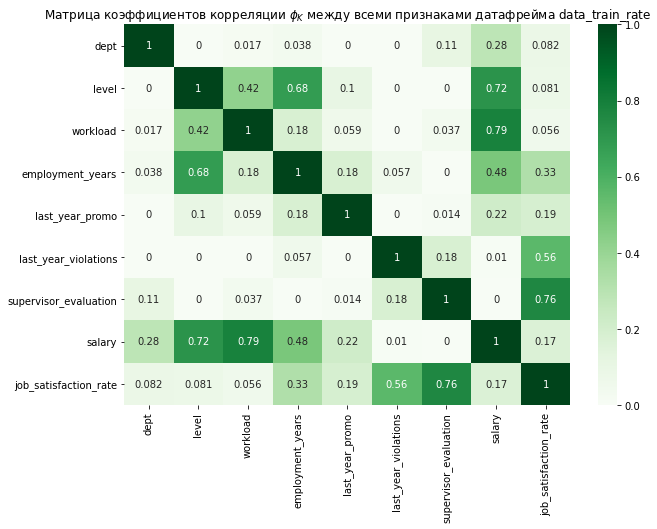

In [21]:
interval_cols = [
    'job_satisfaction_rate',
    'salary'
]

plt.figure(figsize = (10,7))
sns.heatmap(data_train_rate.iloc[:,1:].phik_matrix(interval_cols=interval_cols), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между всеми признаками датафрейма data_train_rate')
plt.show()

Полученные матрицы корреляции позволяют сделать следующие выводы:
- между входными признаками нет мультиколлинеарности
- больше всего целевой признак `job_satisfaction_rate` коррелирует со следующими входными признаками:
   - высокая корреляции с признаком  `supervisor_evaluation` - коэффициент корреляции 0.73
   - заметная корреляции с признаком `last_year_violations` - коэффициент корреляции 0.59
- входной признак `salary` имеет высокую связь с входными признаками `workload` и `level`.

### Подготовка данных

#### Объединение таблиц

Будет удобно сразу объединить тестовую выборку `data_x_test` с реальными значениями оценок удовлетворенности сотрудников `data_y_test_rate`, чтобы не было путаницы при получении прогнозов и оценивания метрик модели, так как мы видели, что порядок строк отличается в тестовом датафрейме и в датафрейме с тестовыми оценками удовлетворенностью. Применим метод `merge`, указав в стобце для объединения `id` и проверим, что при объединении не образовалось новых пропусков.

In [22]:
data_test_rate = data_x_test.merge(data_y_test_rate, how = 'left',on = 'id')
data_test_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.56
1996,109582,technology,middle,low,3,no,no,2,21600,0.14
1997,305653,technology,junior,low,1,no,no,3,14400,0.11
1998,160233,technology,middle,low,8,no,no,1,32400,0.43


Проверим, что не образовалось новых пропусков

In [23]:
data_test_rate.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

**Таблицы `data_x_test` и `data_y_test_rate` объединены в датафрейм `data_test_rate`. Оценки удовлетворенности сотрудников корректно проставились к каждому объекту**

#### Подготовка данных при помощи ColumnTransformer

Так как мы помимо деревянной модели будем использовать линейную модель, то для нее важно задать порядок значений в признаках, которые поддаются ранжированию. У нас есть признаки, которые можно легко категоризовать - для них будем использовать OrdinalEncoder(), а есть признаки, которые не ранжируются - для них будем использовать OneHotEncoder(). Хоть признак с профессиями и имеет 5 уникальных значений, а значит при кодировании в OHE и при применении параметра `drop=first` создастся 4 новых столбца, что не пойдет на пользу нелинейной модели, но у нас также есть и линейная модель, которая может найти взаимосвязи там где их нет, если мы передадим столбец с профессиями в OrdinalEncoder(). Поэтому хоть мы и создадим 4 новых признака, что не пойдет на пользу нелинейной модели, но зато не запутает линейную. Если бы мы выполняли подготовку по-разному для двух разных моделей, то тогда для нелинейной модели мы бы кодировали в своем пайплайне все категориальные признаки только при помощи OrdinalEncoder(). Также так как у нас есть явные и неявные пропуски в категориальных столбцах, то при использовании кодировщиков OneHotEncoder() и OrdinalEncoder() нужно использовать обработку пропусков и замену их на моды. 

Количественные признаки будем масштабировать изначально при помощи `StandardScaler()`, потом через словарь с гиперпараметрами добавим еще `MinMaxScaler()`. Так как для линейной модели важно задать порядок признакам, которые ранжируются, то к признакам `level`, `workload`, `last_year_promo`, `last_year_violations` будем применять `OrdinalEncoder()`. Признак `dept`, который номинальный и ранжированию не поддаются, будем кодировать при помощи OneHotEncdoder(). 

**Разделение признаков на порядковые и номинальные будет следующим:**
 - `dept` нельзя проранжировать, поэтому его будем кодировать при помощи OneHotEncoder()
 - `level`, `workload`, `last_year_promo`, `last_year_violations` можно проранжировать, поэтому для них создадим словарь `categories` и будем кодировать при помощи `OrdinalEncoder()`.

Для начала создадим отдельные списки для столбцов, которые будут масштабироваться и кодироваться разными способами.

In [24]:
ohe_columns = [
    'dept'
]

ord_columns = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

num_columns = ['employment_years',
               'supervisor_evaluation',
               'salary'] 

Так как в нашем исследовании есть отложенная тестовая выборка, которую нам предоставили для окончательной оценки работы модели, а валидацию модели мы производить не будем на отдельной валидационной выборке, так как лучшие значения гиперпараметров будут подбираться автоматизированным путем при помощи GridSearch(), а метрики считаться кросс-валидацией, то использовать `train_test_split` не надо и делить тренировочный датасет на тренировочную и валидационную выборки. Даже в случае дополнительной настройки модели мы все равно будем изменять гиперпараметры в пайплайне и метрика также будет считаться кросс-валидацией. Поэтому просто присвоим переменным `X_train` и `y_train` верные столбцы со значениями.

Перед тем как делить данные на тренировочные и тестовые датасеты для обучения моделей проверим наличие явных дубликатов в тренировочном датасете: нам необходимо проверить сколько явных дубликатов останется после удаления столбца `id`, но до удаления целевого признака `job_satisfaction_rate` из тренировочного датасета, так как строки с одинаковыми значениями во всех входных признаках, но с разными значениями целевого признака, важны при обучении модели. 

In [26]:
data_train_rate.drop('id',axis = 1).duplicated().sum()

245

245 одинаковых строк с одинаковыми входными и целевым признаками, эти строки не помогут модели при обучении, подготовим данные для обучения моделей без учета этих строк в тренировочных данных

In [27]:
#объявляем константы
RANDOM_STATE = 42

#создадим датафрейм с тренировочными данными без учета явных дубликатов, появившихся после удаления столбца с id
X_train = data_train_rate.drop('id',axis = 1).drop_duplicates().drop('job_satisfaction_rate',axis = 1)
y_train = data_train_rate.drop('id',axis = 1).drop_duplicates()['job_satisfaction_rate']

#подготавливаем тестовые данные
X_test = data_test_rate.drop(['id','job_satisfaction_rate'], axis=1)
y_test = data_test_rate['job_satisfaction_rate']

Создаем пайплайн для предобрабоки данных с заменой пропусков на моду. Не забываем создать список `categories`, чтобы передать его в Ordinal encoder с указанием всех ранжированных признаков

In [35]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков (хоть в данном случае у нас их нет,
#но оставим сразу для использования в будущем) и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OHE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle','senior'], 
                    ['low', 'medium','high'],
                    ['no','yes'],
                    ['no','yes'] 
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(cat...=[['junior',
                                              

**Создан пайплайн `data_preprocessor` для подготовки данных**

**На этапе подготовки данных были проделаны следующие действия:**
- таблицы `data_x_test` и `data_y_test_rate` объединены в датафрейм `data_test_rate`. Оценки удовлетворенности сотрудников корректно проставились к каждому объекту
- создан пайплайн `data_preprocessor` для подготовки всех данных

### Обучение моделей

Наша задача состоит в нахождении оценки удовлетворенности сотрудников, целевой признак является непрерывной величиной, хоть и ограничен на отрезке от 0 до 1, поэтому обучать будем регрессионные модели для прогнозирования непрерывных величин. Для обучения сразу нескольких моделей и подбора к ним гиперпараметров будем использовать пайплайн. В качестве моделей используем LinearRegression() и DecisionTreeRegressor().  Оценивать работу модели будем написанной нами метрикой SMAPE, необходимый критерий для лучшей модели: SMAPE <= 15 на тестовой выборке

#### Создание метрики SMAPE

Работу по созданию пайплайна начнем с написания своей собственной функции в качестве метрики SMAPE («симметричное среднее абсолютное процентное отклонение»), которая на вход может получать данные pandas или  массивы NumPy, преобразовывать их в нужные массивы NumPy. 

In [36]:
# на вход функция получает реальные значения и прогноз с предсказанными значениями
def smape_score (y_real,y_preds):
    n = len(y_real)
#отдельно считаем числитель
    numerator = np.abs(y_real - y_preds)
#отдельно считаем знаменатель    
    denominator = np.abs(y_real + y_preds)/2    
    return  100 / n * np.sum(numerator / denominator) 

Для того, чтобы использовать свою метрику при автоматизированном поиске, используем функцию `make_scorer`, передав в нее свою созданную метрику `smape_score` и установив параметр `greater_is_better` в значение `False`, так как в нашем случае чем метрика меньше, тем лучше. Если захотим вывести итоговую таблицу работы всех моделей `cv_results_`, то просто умножим столбец со значением метрики на `-1`, чтобы увидеть реальное значение метрики

In [37]:
smape_score_sv = make_scorer(
    smape_score,
    greater_is_better=False
)

Проверим работу метрики, задав в нее для примера значение целевого признака `job_satisfaction_rate` тестового датафрейма `data_test_rate` в качестве `y_real`, а в качестве `y_preds` вставим сначала значение еще раз этого же столбца и убедимся, что метрика равно 0, так как отклонений в значениях нет, а потом попробуем добавить небольшую константу  и отнять у столбца `job_satisfaction_rate`, чтобы убедиться, что метрика начала увеличиваться, используем вызов самой функции `smape_score`, так как мы не выполняем автоматизированный поиск и не используем сейчас кросс-валидацию.

In [38]:
print('Метрика SMAPE при передаче одного и того же столбца:', smape_score(data_test_rate['job_satisfaction_rate'],data_test_rate['job_satisfaction_rate']))
print('Метрика SMAPE при добавлении 0.05 к исходному столбцу:', smape_score(data_test_rate['job_satisfaction_rate'],data_test_rate['job_satisfaction_rate']+0.05))
print('Метрика SMAPE при добавлении 0.07 к исходному столбцу:', smape_score(data_test_rate['job_satisfaction_rate'],data_test_rate['job_satisfaction_rate']+0.07))
print('Метрика SMAPE при вычитании 0.07 от исходного столбца:', smape_score(data_test_rate['job_satisfaction_rate'],data_test_rate['job_satisfaction_rate']-0.07))


Метрика SMAPE при передаче одного и того же столбца: 0.0
Метрика SMAPE при добавлении 0.05 к исходному столбцу: 11.233887643416896
Метрика SMAPE при добавлении 0.07 к исходному столбцу: 15.216853070141026
Метрика SMAPE при вычитании 0.07 от исходного столбца: 22.139389364241723


При увеличении/уменьшении первоначального массива со значениями метрика действительно увеличивается. Метрика SMAPE подготовлена

#### Создание словаря с  гиперпараметрами для моделей и масштабирования

Сперва посмотрим какие гиперпараметры мы сможем подобрать и указать в словаре для автоматизированного подбора в общем пайплайне.

Спервая глянем возможные гиперпараметры для DecisionTreeRegressor()

In [39]:
model_tree = DecisionTreeRegressor()
model_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

Используем `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`. Создадим словарь с гиперпараметрами. Также добавим в словарь гиперпараметров масштабирование `MinMaxScaler()` и вариант без масштабирования `passthrough`.

In [40]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__min_samples_split' : range(2,5),
        'models__min_samples_leaf' : range(1,3),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Теперь рассмотрим возможные гиперпараметры модели LinearRegression():

In [41]:
model_linear = LinearRegression()
model_linear.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Добавим `copy_X`, `fit_intercept`, `positive` в словарь с гиперпараметрами

In [42]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__min_samples_split' : range(2,5),
        'models__min_samples_leaf' : range(1,3),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__fit_intercept': [True,False],
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

**Получился итоговый список словарей с гиперпараметрами для моделей**

#### Создание итогового пайплайна

Теперь объединим все в итоговый пайплайн, в качестве инструмента для автоматизированного поиска гиперпараметров сначала будем использовать GridSearchCV(), так как модели всего 2 и сначала будем задавать небольшие диапазоны значений гиперпараметров. у LinearRegressor() не будем добавлять вариант без масштабирования, так как линейная модель очень сильно зависит от задаваемых диапазонов значений

In [43]:
pipe_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__min_samples_split' : range(2,5),
        'models__min_samples_leaf' : range(1,3),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__fit_intercept': [True,False],
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

#собственная функция для подсчета метрики SMAPE
def smape_score (y_real,y_preds):
    n = len(y_real)
#отдельно считаем числитель
    numerator = np.abs(y_real - y_preds)
#отдельно считаем знаменатель    
    denominator = np.abs(y_real + y_preds)/2    
    return  100 / n * np.sum(numerator / denominator) 

#используем make_scorer для использования собственной функции при подсчете метрики в автоматизированном поиске GridSearchCV()
smape_score_sv = make_scorer(
    smape_score,
    greater_is_better=False
)

# запускаем таймер для проверки длительности поиска при GridSearchCV
start = time.time()

grid = GridSearchCV(
    pipe_one, 
    param_grid=param_grid, 
    cv=5, 
    scoring= smape_score_sv,
    n_jobs=-1
)
grid.fit(X_train, y_train) 

grid_search_time = time.time() - start
print('\n\nХарактеристики при GridSearchCV')
print(f'Время подбора гиперпараметров для моделей: {grid_search_time}')

print('Лучшая модель и её параметры на тренировочном датасете:\n\n', grid.best_estimator_)
print('Метрика SMAPE для лучшей модели, полученная при кросс-валидации:\n', grid.best_score_)



Характеристики при GridSearchCV
Время подбора гиперпараметров для моделей: 31.73828363418579
Лучшая модель и её параметры на тренировочном датасете:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
 

Время работы GridSearchCV() составило 31 секунду. Метрика лучшей модели получилась -23.35 (минус появился из-за того, что мы установили параметр `greater_is_better=False`, так как алгоритм все равно считает самое большее число метрики лучшим, то мы перед значениями метрики оставили минус, чтобы это соответствовало нашей задаче, где меньшее значение метрики - лучше). Нам такой результат, конечно, не подходит. Так как для модели в LinearRegression() перебраны все варианты гиперпараметров, но лучшая модель все равно получилась DecisionTreeRegressor(), то теперь будем менять диапазоны значений гиперпараметров у модели дерева решений, увеличивая их. Также изменим инструмент автоматизированного поиска гиперпараметров на RandomizedSearchCV(), так как время поиска при GridSearchCV() составит будет сильно велико. Перепишем блок для пайплайна

Увеличим рассматриваемые диапазоны гиперпараметров для модели дерева решений и поменяем GridSearchCV() на RandomizedSearchCV():

`'models__max_depth': range(2,16),
 'models__min_samples_split' : range(2,8),
 'models__min_samples_leaf' : range(1,6),
 'models__max_features': range(2,9),`

In [44]:
pipe_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__fit_intercept': [True,False],
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

#собственная функция для подсчета метрики SMAPE
def smape_score (y_real,y_preds):
    n = len(y_real)
#отдельно считаем числитель
    numerator = np.abs(y_real - y_preds)
#отдельно считаем знаменатель    
    denominator = np.abs(y_real + y_preds)/2    
    return  100 / n * np.sum(numerator / denominator) 

#используем make_scorer для использования собственной функции при подсчете метрики в автоматизированном поиске GridSearchCV()
smape_score_sv = make_scorer(
    smape_score,
    greater_is_better=False
)

start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_one, 
    param_distributions=param_grid, 
    cv=5,
    scoring = smape_score_sv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 10
    n_iter=10
)
randomized_search.fit(X_train, y_train)

randomized_search_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SMAPE для лучшей модели, полученная при кросс-валидации:', randomized_search.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 1.7743268013000488
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                      

Время поиска составило всего 1.7 секунд, но метрика в этом случае составила 15.8, необходимо еще немного ее улучшить. Так как поиск рандомизированный, то попробуем увеличить кол-во итераций `n_iter` с 10 до 80 для более длительного поиска лучшей модели.

In [45]:
pipe_one = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__copy_X': [True,False], 
        'models__fit_intercept': [True,False],
        'models__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

#собственная функция для подсчета метрики SMAPE
def smape_score (y_real,y_preds):
    n = len(y_real)
#отдельно считаем числитель
    numerator = np.abs(y_real - y_preds)
#отдельно считаем знаменатель    
    denominator = np.abs(y_real + y_preds)/2    
    return  100 / n * np.sum(numerator / denominator) 

#используем make_scorer для использования собственной функции при подсчете метрики в автоматизированном поиске GridSearchCV()
smape_score_sv = make_scorer(
    smape_score,
    greater_is_better=False
)

start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_one, 
    param_distributions=param_grid, 
    cv=5,
    scoring = smape_score_sv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 80
    n_iter=80
)
randomized_search.fit(X_train, y_train)

randomized_search_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SMAPE для лучшей модели, полученная при кросс-валидации:', randomized_search.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 13.85731816291809
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                       

Время подбора лучшей модели составило 13.8 секунды. Метрика SMAPE при кросс-валидации составила 15.4. 

**Лучшая модель и гиперпараметры оказались следующими: модель DecisionTreeRegressor(max_depth=15, max_features=7, min_samples_leaf=1, min_samples_split=7, random_state=42), метод масштабирования MinMaxScaler()**

При подборе гиперпараметров на GridSearch()  метрика увеличилась буквально на 0.1, но зато время подбора параметров увеличилось до 17 минут, поэтому оставляем рандомизированный поиск гиперпараметров в качестве основного.

Выведем таблицу со всеми результатами `cv_results` и посмотрим все гиперпараметры лучшей модели

In [47]:
#команды для отображения таблиц целиком
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#получаем таблицу с работой всех моделей
result_models_rate = pd.DataFrame(randomized_search.cv_results_)

#для корректного отображения среднего значения метрики SMAPE умножаем столбец на -1 
result_models_rate[
    'mean_test_score'
] = result_models_rate['mean_test_score'] * -1 

#отображаем нужные столбцы и выводим для наглядности первые 5 лучших моделей
display(result_models_rate[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(5) )

,rank_test_score,param_models,mean_test_score,params
56,1,DecisionTreeRegressor(random_state=42),15.400886,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
67,2,DecisionTreeRegressor(random_state=42),15.525288,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 6, 'models__min_samples_leaf': 1, 'models__max_features': 7, 'models__max_depth': 15, 'models': DecisionTreeRegressor(random_state=42)}"
11,3,DecisionTreeRegressor(random_state=42),15.744441,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 3, 'models__max_features': 6, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"
0,4,DecisionTreeRegressor(random_state=42),15.752247,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 1, 'models__max_features': 8, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
17,5,DecisionTreeRegressor(random_state=42),15.796110,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 2, 'models__max_features': 6, 'models__max_depth': 12, 'models': DecisionTreeRegressor(random_state=42)}"


Благодаря этой таблице,  мы видим все подобранные значения гиперпараметров для лучшей модели

*На этапе составления полного пайплайна была подобрана модель с лучшими гиперпараметрами:*

**Модель DecisionTreeRegressor(max_depth=15, max_features=7, min_samples_leaf=1, min_samples_split=7, random_state=42), метод масштабирования MinMaxScaler()**

Время подбора лучшей модели составило 13.2 секунды. Метрика SMAPE при кросс-валидации составила 15.4. 

#### Анализ важности признаков

Теперь взглянем на коэффициенты важности признаков, рассчитанные моделью

In [49]:
#создаем датафрейм для значений важности и наименований каждого столбца
feature_importances_regressor = pd.DataFrame(
    {
        'Feature': randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': round(pd.Series(randomized_search.best_estimator_.named_steps['models'].feature_importances_),2)
    })

Визуализируем рассчитанные моделью коэффициенты важности признаков

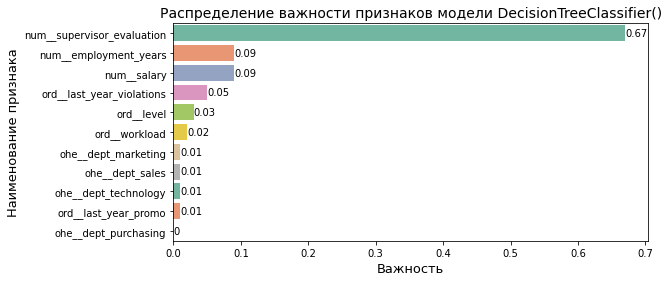

In [50]:
#рисуем график важности признаков
plt.figure(figsize=(8.5, 4))
ax = sns.barplot(x = 'Importance', y = 'Feature' , data = feature_importances_regressor.\
                         sort_values(by='Importance', ascending = False), palette = 'Set2')

#указываем значения на каждой оси
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Важность', fontsize = 13)
plt.ylabel('Наименование признака', fontsize = 13)
plt.title('Распределение важности признаков модели DecisionTreeClassifier()', fontsize = 14)
plt.show()

**Полученный график показывает, что прогнозируемая моделью величина оценки удовлетворенности:**
- больше всего зависит от оценки непосредственного руководителя
- меньше всего зависит от отдела, в котором работает сотрудник 

#### Проверка на тестовых данных

Осталось проверить, что метрика не сильно ухудшается на тестовых данных. Сделаем прогноз с помощью лучшей обученной модели и посмотрим на метрику. 

In [51]:
# проверяем работу лучшей модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_rate_predict = randomized_search.predict(X_test)
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {smape_score(y_test, y_test_rate_predict)}')

Метрика SMAPE лучшей модели на тестовой выборке: 13.901284205176058


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Появилось предупреждение о том, что некоторые данные в столбцах пропущены и во время кодировки будут преобразованы в нулевую категорию. Это правило мы устанавливали в кодировщике OHE, на этапе предобработки мы видели эти пропуски. Значение метрики на тестовой выборке соответсвует условию в задании (<=15), можно сделать промежуточные выводы по работе моделей.

Осталось проверить модель на адекватность

#### Проверка модели на адекватность

Осталось сравнить результаты, предсказанные с помощью нашей лучшей модели, с результатами модели `DummyRegressor()`. Эта модель использует несколько типов стратегий, мы остановимся на стандартном, когда всем прогнозным значениям присваивается среднее значение целевого признака

Для начала выведем  прогнозные значения лучшей модели

In [52]:
# проверяем работу лучшей модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_rate_predict = randomized_search.predict(X_test)
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {smape_score(y_test, y_test_rate_predict)}')

Метрика SMAPE лучшей модели на тестовой выборке: 13.901284205176058


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Объявим константную модель, в качестве стратегии укажем `mean`. Обучим ее на тренировочном датасете, получим прогноз тестового датасета и сравним метрику SMAPE у нее и у нашей лучшей модели. Для модели DummyRegressor() не будем подготавливать тренировочныее данные, так как она использует значения целевого признака для предсказания

In [53]:
#объявляем модель и указываем тип стратегии
dummy_model_regression = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

#получаем прогнозные значения DummyRegressor()
dummy_regression_predict = dummy_model_regression.predict(X_test)
#считаем метрику SMAPE и выводи ее, так как не используем кросс-валидацию, то используем непосредственно функцию smape_score
print(f'Метрика SMAPE Dummy модели на тестовой выборке: {smape_score(y_test, dummy_regression_predict)}')

Метрика SMAPE Dummy модели на тестовой выборке: 38.26225790202238


**Наша лучшая модель справилась с проверкой на адекватность и показала метрику SMAPE намного ниже, чем у константной модели DummyRegressor()**

#### Результаты обучения моделей

**При составлении пайплайна для подбора гиперпараметров сразу нескольким моделям были проделаны следующие шаги и получены следующие результаты**
- создан итоговый пайплайн, включающий:
  - подготовку данных:
   - использование двух методов кодирования категориальных признаков: при помощи OneHotEncoder() и OrdinalEncoder()
   - использование нескольких вариантов масштабирования количественных признаков: MinMaxScaler(), StandardScaler() и вариант без маштабирования
   - перебор моделей DecisionTreeRegressor() и LinearRegression() с со словарями их гиперпараметров при помощи инструментов автоматизированного подбора GridSearchCV() и RandomizedSearchCV().
- для оценивания качества работы моделей была созданна собственная метрика SMAPE, которая при помощи make_scorer была применена при автоматизированном поиске гиперпараметров
- при помощи инструмента автоматизированного подбора гиперпараметров RandomizedSearchCV() для моделей  были получены следующие результаты:
  - **лучшей моделью оказалась модель DecisionTreeRegressor(max_depth=15, max_features=7, min_samples_leaf=1, min_samples_split=7, random_state=42), метод масштабирования MinMaxScaler()**

  - лучшая модель была подобрана за 13.8 секунды.
  - метрика SMAPE составила:
    - при кросс-валидации 15.4
    - на тестовом набобре данных 13.9
- также модель прошла проверку на адекватность, метрика SMAPE оказалась намного ниже, чем у модели DummyRegressor()

При анализе важности признаков оказалось, что прогнозируемая моделью величина оценки удовлетворенности:
- больше всего зависит от оценки непосредственного руководителя
- меньше всего зависит от отдела, в котором работает сотрудник 

## Этап второй: предсказание увольнения сотрудника из компании

### Загрузка и изучение данных

Загружаем файлы датасетов, создаем датафреймы, выводим первые 15 строк и основную информацию о них для ознакомления, тестовые данные точно такие же, как и в прошлый раз, поэтому используем просто таблицу из прошлого этапа работы

In [54]:
pth1 = '/datasets/train_quit.csv'
pth2 = 'https://.../datasets/train_quit.csv' #часть ссылки скрыта ввиду NDA
pth3 = 'train_quit.csv'
if os.path.exists(pth1):
    data_train_quit = pd.read_csv(pth1, sep=',', decimal = '.')
    data_x_test_quit = data_x_test.copy()
    data_y_test_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',', decimal = '.')
#добавляем проверку корректности url ссылки при помощи requests.get(url) и проверки status_code == 200
elif requests.get(pth2).status_code == 200:
    data_train_quit = pd.read_csv(pth2, sep=',', decimal = '.')
    data_x_test_quit = data_x_test.copy()
    data_y_test_quit = pd.read_csv('https://.../datasets/test_target_quit.csv', sep=',', decimal = '.') #часть ссылки скрыта ввиду NDA
elif os.path.exists(pth3):
    data_train_quit = pd.read_csv(pth3, sep=',', decimal = '.')
    data_x_test_quit = data_x_test.copy()
    data_y_test_quit = pd.read_csv('test_target_quit.csv', sep=',', decimal = '.')
else:
    print('Something is wrong')


#выводим первые 15 строк и основную информацию для каждого датафрейма    
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    display(d.head(15))
    d.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


**Созданные датафреймы:**
- имеют следующие размерности:
    - data_train_quit - 4000 строк;
    - data_x_test_quit - 2000 строк (дублирует data_x_test);
    - data_y_test_quit - 2000 строк;
- имеют явные пропуски
- столбцы имеют корректные типы данных
- названия столбцов приведены к змеиному "регистру"
- при первичном ознакомлении неявные дубликаты не выделяются

###  Предобработка данных

Выполняем такую же предобработку данных, как и на первом этапе работы, для комплектности всех датафреймов везде также присутствует`data_x_test_quit`, хоть это копия `data_x_test`, который мы уже предобработали во время первого этапа работы

#### Переименование столбцов

Так как столбцы приведены к змеиному регистру, то нам остается проверить, что столбцы в `data_train_quit`(без учета столбца с целевым признаком `quit`) имеют точно такие же названия столбцов и порядок, что и в `data_x_test_quit`. При прогнозировании очень важно передать в модель тот же самый порядок и наименования столбов, что использовались при обучении.

In [55]:
data_train_quit.columns.tolist()[:-1] == data_x_test_quit.columns.tolist()

True

Названия полностью совпали. Остается проверить, чтобы не было лишних пробелов в названиях столбцов

In [56]:
for d in data_train_quit,data_x_test_quit,data_y_test_quit:
    print(d.columns.tolist())

['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary', 'quit']
['id', 'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation', 'salary']
['id', 'quit']


Лишних пробелов нет

**Столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.**

#### Проверка пропусков

Посчитаем все явные пропуски в датафреймах, подтвердив результаты первичного ознакомления:

In [57]:
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    print(d.isna().sum().sort_values(ascending = False))

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
dept                     2
level                    1
id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
id      0
quit    0
dtype: int64


**Столбцы нового тренировочного датафрейма `data_train_quit` и нового тестового целевого признака `data_y_test_quit` не имеют явных пропусков** Оставим найденные пропуски в категориальных столбцах тестовой выборки как есть и при построении модели учтем это и добавим при кодировании обработку пропусков при помощи SimpleImputer().

#### Аномальные значения

Выведем описательные статистики для всех количественных столбцов всех датафреймов:

In [58]:
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    display(round(d.describe().T,2))

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28,260158.03,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70,2.54,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47,1.00,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80,15152.42,12000.0,22800.00,30000.0,43200.00,96000.0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.67,2.54,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.53,1.00,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.80,15398.44,12000.0,22800.0,30000.0,43200.00,96000.0


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0


**При первичном ознакомлении со статистиками явных аномалий не наблюдается. При дальнейшем исследовательском анализе посмотрим распределения величин для поиска выбросов и еще раз аномальных значений в новом тренировочном датафрейме. Также наблюдаем, что минимальные и максимальные `id` в тестовых датафреймах совпадают**

**В рассматриваемых датасетах отсутствуют аномальные значения**

#### Изменение типов данных столбцов

Проверим типы данных всех столбцов всех датафреймов:

In [59]:
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    print(d.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id         

**Типы данных столбцов соответствуют значениям в них**

#### Обработка дубликатов

Проверим датафреймы на наличие явных дубликатов

In [60]:
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    print(d.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено. Теперь проверим датафреймы на наличие неявных дубликатов. Сначала проверим все уникальные значения в категориальных столбцах

In [61]:
for d in [data_train_quit,data_x_test_quit,data_y_test_quit]:
    for c in d.select_dtypes(include='object').columns.tolist():
        print(f'Значение столбца {c}: {d[c].unique()}')

Значение столбца dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Значение столбца level: ['middle' 'junior' 'sinior']
Значение столбца workload: ['high' 'medium' 'low']
Значение столбца last_year_promo: ['no' 'yes']
Значение столбца last_year_violations: ['no' 'yes']
Значение столбца quit: ['no' 'yes']
Значение столбца dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Значение столбца level: ['junior' 'middle' 'senior' nan]
Значение столбца workload: ['medium' 'low' 'high' ' ']
Значение столбца last_year_promo: ['no' 'yes']
Значение столбца last_year_violations: ['no' 'yes']
Значение столбца quit: ['yes' 'no']


В новых тренировочном датафрейме и тестовом с целевым признаком явных и неявных дубликатов не обнаружено, только присутствует также некорректно записанное значение `sinior` в столбце `level`. В тестовом датафрейме `data_x_test_quit` также как и на первом этапе есть кроме явных пропусков `nan` еще неявные пропуски ` `, которые мы оставим и обработаем их в пайплайне при помощи ColumnTransformer.

Поменяем некоректное значение `sinior` на корректное `senior`

In [62]:
for d in data_train_quit,data_x_test_quit:
    d['level'] = d['level'].replace('sinior','senior')
    print(d['level'].unique())

['middle' 'junior' 'senior']
['junior' 'middle' 'senior' nan]


Теперь проверим, чтобы не было повторяющихся значений в столбце `id` во всех датафреймах:

In [63]:
for d in  data_train_quit,data_x_test_quit,data_y_test_quit:
    print(f"Кол-во дубликатов: {d['id'].duplicated().sum()}")

Кол-во дубликатов: 0
Кол-во дубликатов: 0
Кол-во дубликатов: 0


Неявных дубликатов в столбцах с `id` нет. Других критериев кроме `id` для уникальной идентификации сотрудников не задать условиями, поэтому делаем вывод, что явных и неявных дубликатов нет.

**Во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test_quit`, которые будут обработаны в пайплайне во время кодирования значений**

**На этапе предобработки данных были выполнены следующие действия:**
- столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.
- столбцы с должностью `dept` и уровнем квалификации `level` имеют явные пропуски в тестовом датафрейме `data_x_test_quit`. Найденные пропуски в категориальных столбцах при построении модели учтем и добавим при кодировании обработку пропусков.
- явных аномальных значений в данных не обнаружено.
- типы данных столбцов соответствуют значениям в них
- во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test_quit`, которые будут обработаны в пайплайне во время кодирования значений.

### Исследовательский анализ

Выведем все описательные статистики снова для признаков c указанием имен датафреймов

In [64]:
#создадим словарь с нашими датафреймами, чтобы можно было выводить удобно их названия
dataframes_quit = {
    'data_train_quit': data_train_quit,
    'data_x_test_quit': data_x_test_quit,
    'data_y_test_quit': data_y_test_quit,
}
for name, d in dataframes_quit.items():
    print(f'Описательные статистики для {name}')
    display(round(d.describe(),2).T)

Описательные статистики для data_train_quit


,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28,260158.03,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70,2.54,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47,1.00,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80,15152.42,12000.0,22800.00,30000.0,43200.00,96000.0


Описательные статистики для data_x_test_quit


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.67,2.54,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.53,1.00,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.80,15398.44,12000.0,22800.0,30000.0,43200.00,96000.0


Описательные статистики для data_y_test_quit


,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21,253851.33,100298.0,339052.0,550793.0,765763.75,999029.0


- минимальные и максимальные значения, медианные значения и значения каждого квартиля у идентичных по наименованию столбцов тренировочной и тестовой выборки практически одинаковые по всем столбцам при сравнении, обучившись на тренировочных данных, модель должна иметь небольшой разброс при прогнозе
- минимальные и максимальные значения `id` совпадают у тестовых датафреймов

Построим поочередно графики для всех признаков. Сначала построим графики распределения количественных признаков 
для всех датафреймов с разными графиками для дискретных и непрерывных величин. Так как количество строк  в тренировочной датафрейме в 2 раза больше, чем в тестовом как и на первом этапе исследования, то накладывать графики друг на друга особого смысла нет, так как частота встречаемости в первом разе будет намного выше, расположим графики рядом друг с другом

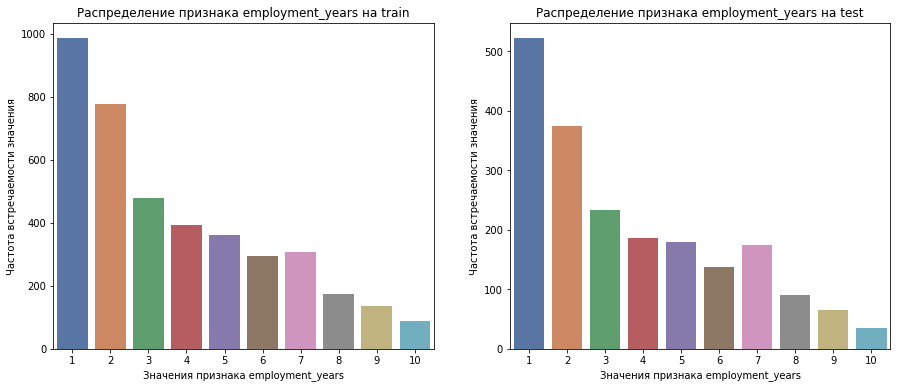

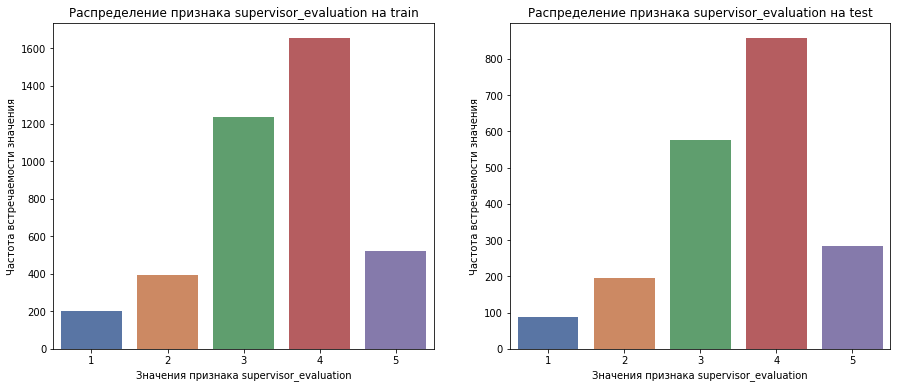

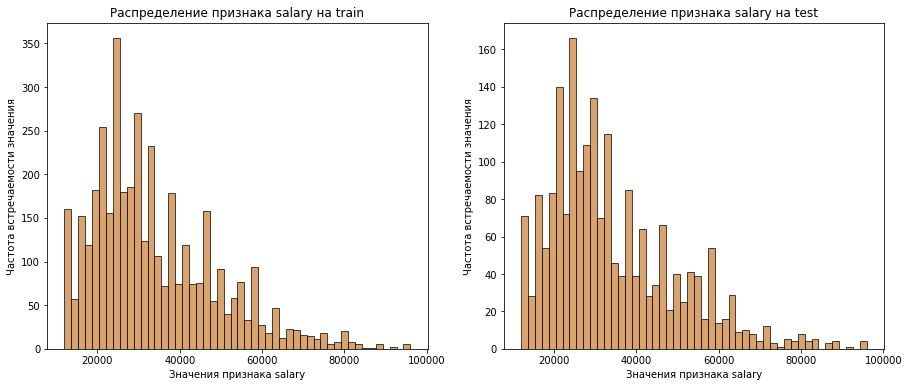

In [65]:
for c in data_train_quit.select_dtypes(exclude='object').columns.tolist()[1:]:
#создаем сразу две фигуры в линию и оси к ней, подписываем оси и наименование графиков
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
        axes[0].set_title(f'Распределение признака {c} на train')
        axes[0].set_xlabel(f'Значения признака {c}')
        axes[0].set_ylabel('Частота встречаемости значения')
        
        axes[1].set_title(f'Распределение признака {c} на test')
        axes[1].set_xlabel(f'Значения признака {c}')
        axes[1].set_ylabel('Частота встречаемости значения')
#условие для построения графиков для дискретных значений (целочисленные и меньше 30 в наборе уникальных значений) 
        if (data_train_quit[c].dtype == 'int64') and (len(data_train_quit[c].unique()) < 30):
            sns.countplot(data = data_train_quit, x=c, palette = 'deep',ax=axes[0])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[0].set_xlabel(f'Значения признака {c}')
            axes[0].set_ylabel('Частота встречаемости значения')
            sns.countplot(data = data_x_test_quit, x=c, palette = 'deep',ax=axes[1])#hue=c, legend=False для версий seaborn до 0.14.0
            axes[1].set_xlabel(f'Значения признака {c}')
            axes[1].set_ylabel('Частота встречаемости значения')
            plt.show()
#оставшиеся значения (с плавающей точкой или целочисленные, но в наборе больше 30 значений)
        else:
            sns.histplot(data = data_train_quit, x = c, color = 'peru', bins = 50,ax=axes[0])
            sns.histplot(data = data_x_test_quit, x = c, color = 'peru', bins = 50,ax=axes[1])
            plt.show()

Теперь посмотрим на распределение категориальных признаков датафреймов

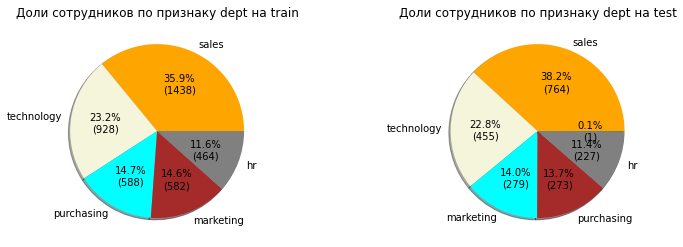

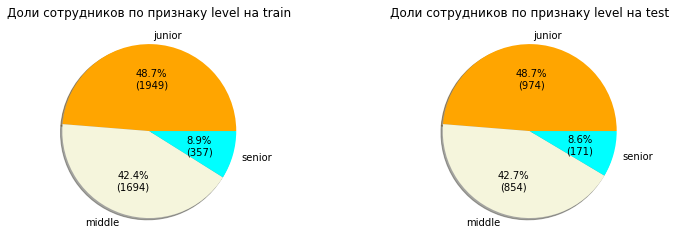

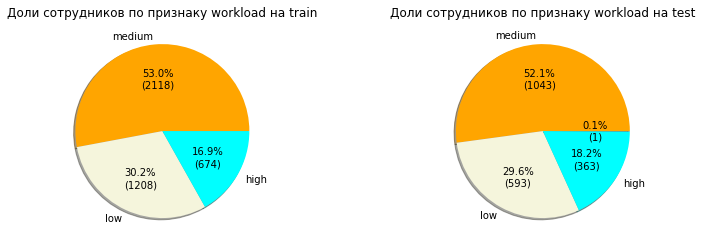

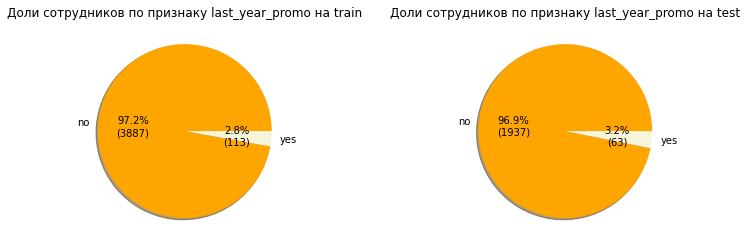

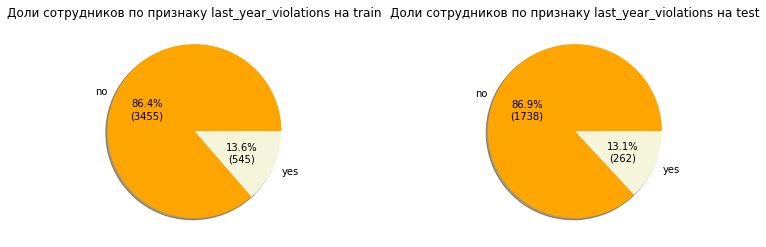

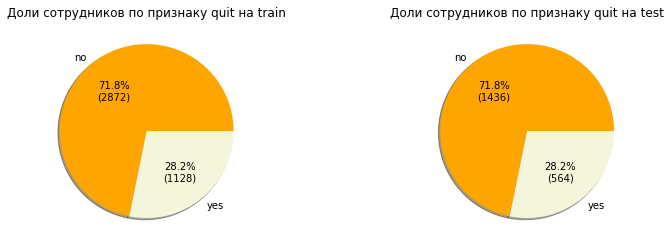

In [66]:
#добавим сразу свой набор цветов для графиков
colors = ("orange", "beige","cyan", "brown","grey", "green")
#создадим список из наименований столбцов со строковыми значениями для использования в цикле
for c in data_train_quit.select_dtypes(include='object').columns.tolist():
#создадим агррегированные таблицы для использования при построении графиков       
    train_pie = data_train_quit.pivot_table(index = c, values = 'id', aggfunc={'count'}).sort_values(by= 'count', ascending = False).reset_index()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12.5,4))
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[0].set_title(f'Доли сотрудников по признаку {c} на train')
    axes[1].set_title(f'Доли сотрудников по признаку {c} на test')
#добавляем конструкцию try-except, чтобы когда очередь дошла до построения целевого признака вместо ошибки значения для axes[1] взялись и другого df  
    try:
        test_x_pie = data_x_test_quit.pivot_table(index = c, values = 'id', aggfunc={'count'}).sort_values(by= 'count', ascending = False).reset_index()
        axes[0].pie(train_pie['count'], labels = train_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_train_rate.shape[0]/100)),\
                colors=colors, shadow=True)
        axes[1].pie(test_x_pie['count'], labels = test_x_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_x_test.shape[0]/100)),\
                colors=colors, shadow=True)
        plt.show()
    except:
        test_y_pie = data_y_test_quit.pivot_table(index = c, values = 'id', aggfunc={'count'}).sort_values(by= 'count', ascending = False).reset_index()
        axes[0].pie(train_pie['count'], labels = train_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_train_rate.shape[0]/100)),\
                colors=colors, shadow=True)
        axes[1].pie(test_y_pie['count'], labels = test_y_pie[c], autopct= lambda x: '{:.1f}%\n({:.0f})'.format(x,(x* data_x_test.shape[0]/100)),\
                colors=colors, shadow=True)
        plt.show()

**Полученные графики для количественных признаков повторяют точно такие же выводы, как и на первом этапе работы:**
- распределения на тренировочном датасете и на тестовом для количественных признаков очень схожи, соблюдены пропорции каждого из признаков, похоже, что один общий датасет разделили на тренировочный и тестовый, указав в стратификации все признаки
- кол-во отработанных лет имеет диапазон значений от 1 до 10 лет. Самое частое значение - 1 год и частота встречаемости плавно уменьшается к 10 годам
- самые частые оценки руководителя - 4 и 3, значит большинство сотрудников выполяют свои должностные обязанности
- медианное значение зарплаты - 30000, всего 25% сотрудников получают зарплату выше 43200, при корреляции посмотрим  как это влияет на удовлетворенность сотрудников.

**Полученные графики для категориальных признаков позволяют сделать точно такие же выводы, как и на первом этапе работы:**
- распределения долей на тренировочном датасете и на тестовом в категориальных признаках также очень схожи, как и у количественных признаков
- по количеству сотрудников на разных должностях распределения долей в тренировочном и тестовом датафрейме получилось следующим:
  - `sales` - 35.9% на тренировочном и 38.2% на тестовом
  - `technology` - 23.2% на тренировочном и 22.8% на тестовом
  - `purchasing` - 14.7% на тренировочном и 13.7% на тестовом
  - `marketing` - 14.6% на тренировочном и 14% на тестовом
  - `hr` - 11.6% на тренировочном и 11.4% на тестовом
- по уровню квалицикации доли сотрудников распределяются следующим образом:
  - `junior` - 48.7% на тренировочном и 48.7% на тестовом
  - `middle` - 42.4% на тренировочном и 42.7% на тестовом
  - `senior` - 8.9% на тренировочном и 8.6% на тестовом
- по загруженности больше всего средняя оценка загруженности `medium` - 53% на тренировочном и 52.1% на тестовом датафрейме
- у подавляющего большинства сотрудников не было повышений за прошлый год - 97.2% на тренировочном и 96.9% на тестовом датафрейме
- у большинства сотрудников не было выявленных нарушений за прошлый год - 86.4% на тренировочном и 86.9% на тестовом датафрейме
- большинство сотрудников представлены из числа неуволившихся: 71.8% на тренировочном датафрейме и 71.8% на тестовой

#### Составление портрета «уволившегося сотрудника».

Для начала посмотрим распределение уволившихся сотрудников по отделам, так как количество сотрудников в каждом отделе разное, то посмотрим какую долю уволившиеся составляют от общего количества в каждом отделе: 

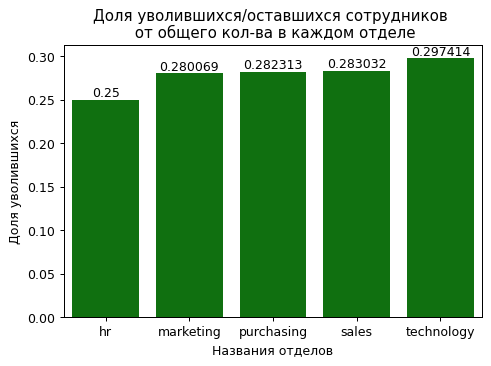

In [69]:
#создаем объект Series, сгруппировав всех сотрудников по отделам и факту увольнения, для отображения доли от общего кол-ва в группе,
#а не самих значений указываем параметр normalize=True
dept_quit_normal = data_train_quit.groupby('dept')['quit'].value_counts(normalize=True)

#из мультииндекса получаем значения только для сотрудников, которые уволились, для удобства построения графика переназначаем индексы
#так как в этой версии pandas нельзя применить reset_index() к Series с мультииндексом, то используем unstack() для превращения 
#Series() сначала в Dataframe(), а уже к нему применяем reset_index()
dept_quit_normal = dept_quit_normal[dept_quit_normal.index.get_level_values(1) == 'yes'].unstack().reset_index()

#строим график
plt.figure(figsize = (6,4), dpi = 90)
ax = sns.barplot(data = dept_quit_normal, x = 'dept', y = 'yes', color = 'green')
#отобрадаем значения на каждом столбце
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Названия отделов') 
plt.ylabel('Доля уволившихся') 
plt.title('Доля уволившихся/оставшихся сотрудников \n от общего кол-ва в каждом отделе')
plt.show() 

Первый график показывает следующее:
- доли уволившихся сотрудников во всех отделах не сильно отличаются
- немного больше увольняется сотрудников из отдела `technology` (0.297 от общего количества сотрудников в отделе)
- меньше всего увольняется сотрудников из отдела `hr` (0.25 от общего количества сотрудников в отделе)

Теперь рассмотрим кол-во уволившихся сотрудников в зависимости от уровня загруженности

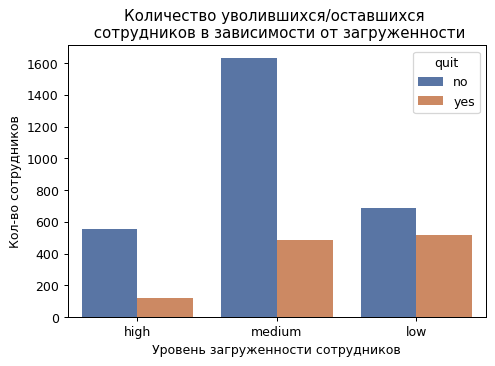

In [71]:
plt.figure(figsize = (6,4), dpi = 90)
sns.countplot(data = data_train_quit, x='workload', palette = 'deep',hue = 'quit')
plt.xlabel('Уровень загруженности сотрудников') 
plt.ylabel('Кол-во сотрудников') 
plt.title('Количество уволившихся/оставшихся \n сотрудников в зависимости от загруженности')
plt.show() 

График показывает, что больше всего сотрудников уволились с низкой загрузкой `low`, если брать в расчет общее кол-во сотрудников в группе, то сотрудники с низкой загрузкой еще более укрепляют свое 'лидирующее' положение по отношению к другим группам

Теперь посмотрим более углубленно -  в каком отделе и с какой нагруженностью больше всего увольняются сотрудники. Для этого создадим дополнительную сводную таблицу с количеством сотрудников в каждой группе такой группе и отсортируем ее по убыванию

In [72]:
#в качестве столбца values зададим salary, чтобы сразу использовать не только количество в группе, но и медианные значения 
#зарплат при дальнейшем сравнении
bar_quit = data_train_quit.pivot_table(index = ('dept','workload','quit'), values = 'salary', aggfunc = {'count','median'}).\
                reset_index(drop=False).sort_values(by=['quit','count'],ascending=False)
#создадим дополнительный столбец, чтобы разделить всех сотрудников на группы 'отдел-загруженность'
bar_quit['dept_workload'] = bar_quit['dept'].astype(str) + ' - ' + bar_quit['workload'].astype(str)
bar_quit.head(5)

,dept,workload,quit,count,median,dept_workload
21,sales,low,yes,187,14400,sales - low
23,sales,medium,yes,177,24000,sales - medium
29,technology,medium,yes,125,30000,technology - medium
27,technology,low,yes,121,19200,technology - low
15,purchasing,low,yes,75,15600,purchasing - low


По данным полученной сводной таблицы построим столбчатую диаграмму

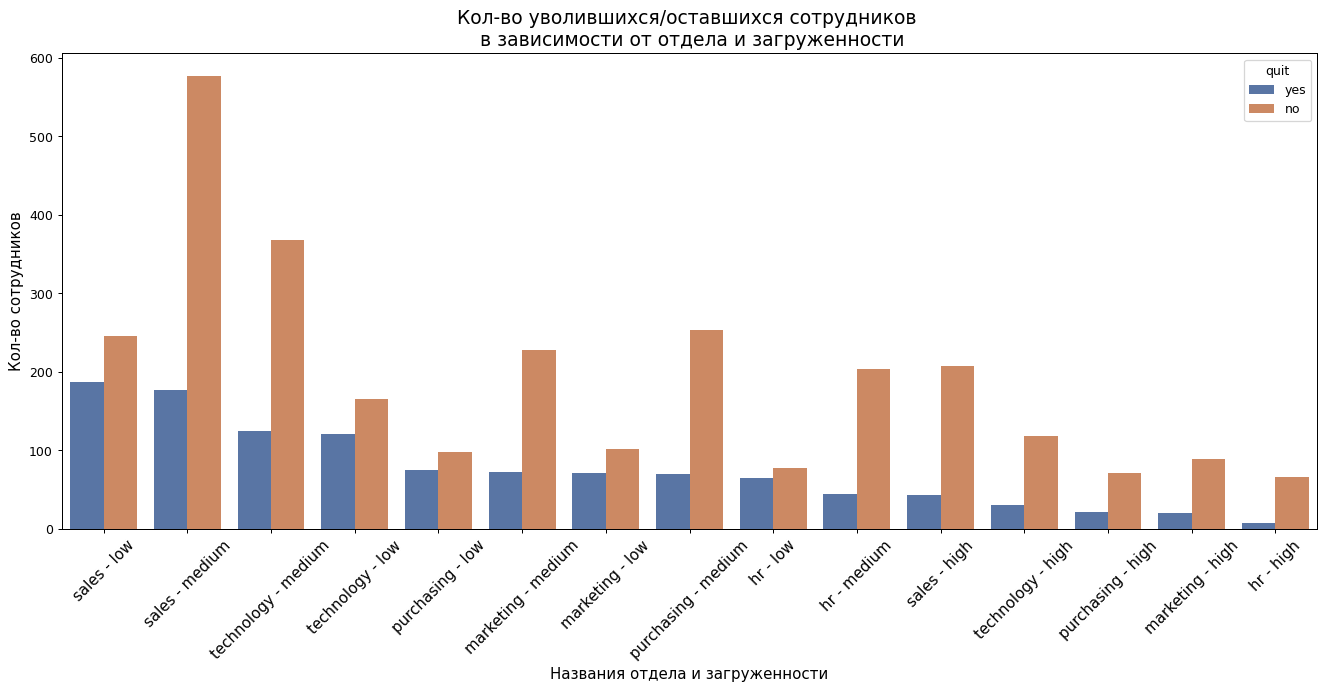

In [73]:
plt.figure(figsize = (18,7), dpi = 90)
sns.barplot(data = bar_quit, x = 'dept_workload', y = 'count', palette = 'deep', hue = 'quit', estimator=np.sum, ci = None)
plt.xlabel('Названия отдела и загруженности', fontsize=12) 
plt.xticks(rotation=45, fontsize=12) 
plt.ylabel('Кол-во сотрудников', fontsize=12) 
plt.title('Кол-во уволившихся/оставшихся сотрудников \n в зависимости от отдела и загруженности', fontsize=15)
plt.show() 

**Полученная диаграмма показывает:**
- по соотношению числа уволившихся к общему числу сотрудников больше всего уволившихся в отделе продаж с низкой загрузкой, что логично, так как зачастую уровень заработка сотрудника в продажах зависит от количества этих самых продаж, а раз нет загруженности, то нет продаж и заработка
- на втором месте по соотношению числа уволившихся к общему числу сотрудников находятся технологи с низкой загрузкой
- на третьем месте по соотношению числа уволившихся к общему числу сотрудников находятся сотрудники отдела закупок с низкой нагрузкой
- наблюдается общая тенденция, что больше всего из отделов увольняются сотрудники с низкой нагрузкой

Теперь рассмотрим средний уровень заработной платы для всех уволившихся сотрудников и всех оставшихся в компании, построим диаграммы рассеяния

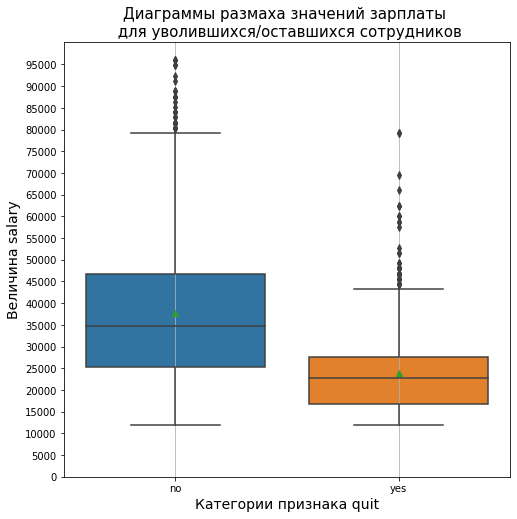

In [74]:
plt.figure(figsize=(8,8))
ax = sns.boxplot(x = 'quit', y = 'salary', showmeans = True, data=data_train_quit)
ax.tick_params(axis='x', labelrotation=0)
#оформляем график и подписываем оси
plt.grid(True, axis = 'x')
ax.set_title('Диаграммы размаха значений зарплаты \n для уволившихся/оставшихся сотрудников', fontsize=15)
ax.set_yticks(np.arange(0, 100000, 5000))
ax.set_xlabel('Категории признака quit', fontsize=14)
ax.set_ylabel('Величина salary', fontsize=14)

# отображаем график
plt.show()

Из-за присутствия большого количества выбросов лучше рассматривать медианное значние зарплат, так как видно, что среднее значение превышает медианное на 5000. Диаграмма показывает следующее:
 - медианное значение заработной платы всех оставшихся сотрудников в компании составляет 35000, что более чем на 10000 выше, чем у уволившихся сотрудников
 - диапазон самых распространенных значений зарплат (межквартильный размах) у всех оставшихся сотрудников выше более чем на 10000, чем у всех уволившихся сотрудников

Теперь подбробней рассмотрим диаграммы размаха зарплат для сотрудников разного уровня квалификации:

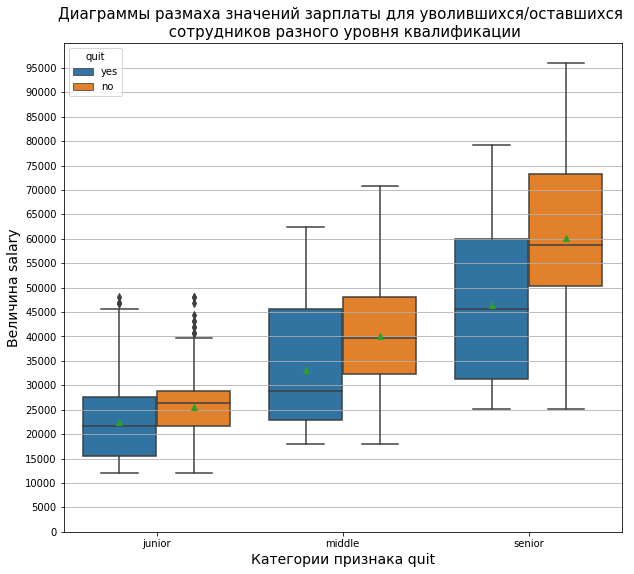

In [75]:
plt.figure(figsize=(10,9))
ax = sns.boxplot(x = 'level', y = 'salary', hue = 'quit', showmeans = True, data=data_train_quit.sort_values(by='level'))
ax.tick_params(axis='x', labelrotation=0)
#оформляем график и подписываем оси
plt.grid(True, axis = 'y')
ax.set_title('Диаграммы размаха значений зарплаты для уволившихся/оставшихся \n сотрудников разного уровня квалификации',
                         fontsize=15)
ax.set_yticks(np.arange(0, 100000, 5000))
ax.set_xlabel('Категории признака quit', fontsize=14)
ax.set_ylabel('Величина salary', fontsize=14)

# отображаем график
plt.show()

Данный график показывает дополнительные особенности:
- разрыв между средним уровнем зарплат у уволившихся сотрудников и оставшихся в компании от начального уровня `junior` до `senior`  увеличивается по мере увеличения уровня квалификации:
  - зарплата оставшихся сотрудников уровня `junior` в среднем на 5000 больше, чем уволившихся такого же уровня
  -  зарплата оставшихся сотрудников уровня `middle` в среднем на 10000 больше, чем уволившихся такого же уровня
  - зарплата оставшихся сотрудников уровня `senior` в среднем на 12000 больше, чем уволившихся такого же уровня


Теперь рассмотрим подробней медианный уровень заработной платы сотрудников в зависимости от их отдела и уровня занятости

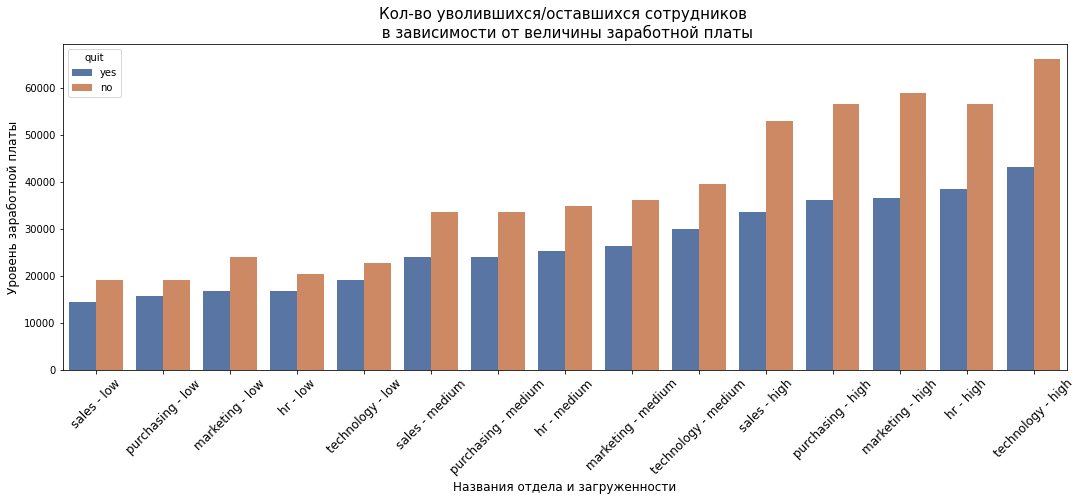

In [76]:
plt.figure(figsize=(18, 6))
sns.barplot(data=bar_quit.sort_values(by=['median','workload',],ascending=True),\
                    x='dept_workload', y='median', hue = 'quit', palette = 'deep',)#, estimator=np.median)
plt.xlabel('Названия отдела и загруженности', fontsize=12) 
plt.xticks(rotation=45, fontsize=12) 
plt.ylabel('Уровень заработной платы', fontsize=12) 
plt.title('Кол-во уволившихся/оставшихся сотрудников \n в зависимости от величины заработной платы', fontsize=15)
plt.show() 

График подтверждает предыдущие выводы:
 - разрыв между медианным уровнем зарплат у уволившихся сотрудников и оставшихся в компании от низкой загруженности к более высокой увеличивается
 - уровень зарплат  увеличивается намного больше от уровня нагруженности у оставшихся сотрудников в компании, у уволившихся сотрудников зарплаты не сильно поднимались на при рассмотрении более высокого уровня загруженности (не более 10000). 

Из распределения долей в категориальных переменных помним, что на диаграмме отображения повышений за прошлый год подавляющее кол-во сотрудников 97% не получало повышение, поэтому добавлять к рассмотрению этот признак не будем

**При составлении портрета «уволившегося сотрудника» полученные графики позволили сделать следующие выводы:**
 - доли уволившихся сотрудников во всех отделах не сильно отличаются
 - немного больше увольняется сотрудников из отдела `technology` (0.297 от общего количества сотрудников в отделе)
 - меньше всего увольняется сотрудников из отдела `hr` (0.25 от общего количества сотрудников в отделе)
 - по отношению кол-ва уволившихся сотрудников к общему кол-ву сотрудников наблюдается общая тенденция, что больше всего из отделов увольняются сотрудники с низкой нагрузкой `low`, если дополнительно рассматривать отделы, то рейтинг уволившихся будет следующим:
   - по соотношению числа уволившихся к общему числу сотрудников больше всего уволившихся в отделе продаж с низкой загрузкой, что логично, так как зачастую уровень заработка сотрудника в продажах зависит от количества этих самых продаж, а раз нет загруженности, то нет продаж
   - на втором месте по соотношению числа уволившихся к общему числу сотрудников находятся технологи с низкой загрузкой
   - на третьем месте по соотношению числа уволившихся к общему числу сотрудников находятся сотрудники отдела закупок с низкой нагрузкой
   
При рассмотрении заработных плат уволившихся/оставшихся в компании сотрудников получились следующие результаты:
 - медианное значение заработной платы всех оставшихся сотрудников в компании составляет 35000, что более чем на 10000 выше, чем у уволившихся сотрудников
 - диапазон самых распространенных значений зарплат (межквартильный размах) у всех оставшихся сотрудников выше более чем на 10000, чем у всех уволившихся сотрудников
 
При рассмотрении уровня квалификации сотрудников и их зарплат получились следующие результаты:
- разрыв между средним уровнем зарплат у уволившихся сотрудников и оставшихся в компании от начального уровня `junior` до `senior`  увеличивается по мере увеличения уровня квалификации:
  - зарплата оставшихся сотрудников уровня `junior` в среднем на 5000 больше, чем уволившихся такого же уровня
  -  зарплата оставшихся сотрудников уровня `middle` в среднем на 10000 больше, чем уволившихся такого же уровня
  - зарплата оставшихся сотрудников уровня `senior` в среднем на 12000 больше, чем уволившихся такого же уровня
  
При дополнительном рассмотрении уровня зарплат у сотрудников разных отделов и разной загруженности получились следующые выводы:
  - разрыв между медианным уровнем зарплат у уволившихся сотрудников и оставшихся в компании от низкой загруженности к более высокой увеличивается
 - уровень зарплат  увеличивается намного больше от уровня нагруженности у оставшихся сотрудников в компании, у уволившихся сотрудников зарплаты не сильно поднимались при рассмотрении более высокого уровня загруженности. 
 
**Исходя из вышеполученных результатов, можно составить портрет `уволившегося сотрудника`:**
 - это сотрудники с низким уровнем загруженности, преимущественно в отделе продаж и технологическом отделе с существенной разницей в уровне зарплаты между сотрудниками такой же квалификации (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000) и с небольшим увеличением в зарплате при работе на более высоком уровне загруженности (не более 10000).

#### Изучение взаимосвязи уровня удовлетворенности и увольнения сотрудников

Для того, что бы изучить корреляцию целевых признаков 2 разных тестовых датафреймов из первого и второго этапа работы нам необходимо соединить две таблицы с целевыми признаками тестовых выборок `data_y_test_rate` и `data_y_test_quit` по столбцу `id`

In [77]:
corr_rate_quit = data_y_test_rate.merge(data_y_test_quit, how = 'inner', on = 'id')

Проверим пропуски

In [78]:
corr_rate_quit.isna().sum()

id                       0
job_satisfaction_rate    0
quit                     0
dtype: int64

Отлично, все значения `id` из первого целевого признака соответствуют значениям `id` во втором целевом признаке. Теперь посмотрим распределения целевого признака `job_satisfaction_rate` в двух разных группах сотрудников и наложим их друг на друга. Так как выборки разного размера, нужна нормализация по плотности, поэтому добавим параметры "stat='density', common_norm=False" в методе ".histplot()".

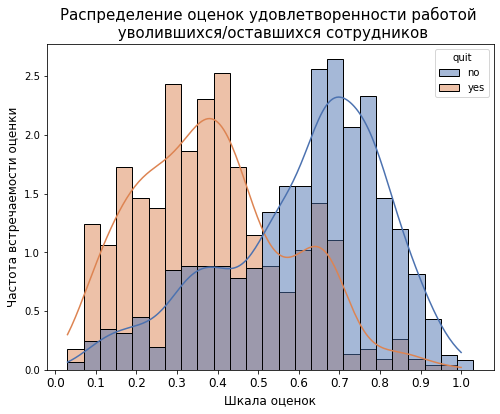

In [79]:
plt.figure(figsize=(8, 6))
sns.histplot(data=corr_rate_quit, x='job_satisfaction_rate', binwidth=0.04, hue='quit', 
             kde = True, palette = 'deep', bins = 80, stat='density', common_norm=False)
plt.xlabel('Шкала оценок', fontsize=12) 
plt.xticks(np.arange(0, 1.1, 0.1), rotation=0, fontsize=12, ) 
plt.ylabel('Частота встречаемости оценки', fontsize=12) 
plt.title('Распределение оценок удовлетворенности работой \n уволившихся/оставшихся сотрудников', fontsize=15)
plt.show() 

Дополнительно посмотрим коэффициент корреляции между величинами, заменив значения столбца `quit` на 0 и 1

In [80]:
corr_rate_quit['quit'] = corr_rate_quit['quit'].replace('no',0).replace('yes',1)

round(corr_rate_quit['quit'].corr(corr_rate_quit['job_satisfaction_rate']),2)

-0.46

*Полученные результаты показывают:*
- связь между целевыми признаками 'quit' и 'job_satisfaction_rate' заметная, коэффициент корреляции при этом: - 0.46
- оценка удовлетворенности и кол-во уволившихся сотрудников связаны обратной нелиннейной связью - при увеличении оценки удовлетворенности сотрудников снижается количество уволившихся сотрудников
- распределения оставшихся и уволившихся сотрудников имеет пересечение в области оценки удовлетворенности 0.4. При оценке удовлетворенности ниже 0.4 кол-во уволившихся растет по сранению с кол-вом оставшихся сотрудников. При оценке же оценки от 0.4 и выше кол-во оставшихся в компании растет стремительными темпами по сравнению с кол-вом уволившихся сотрудником.

**На этапе исследовательского анализа были получены следующие результаты:**

**Полученные графики для количественных признаков повторяют точно такие же выводы, как и на первом этапе работы:**
- распределения на тренировочном датасете и на тестовом для количественных признаков очень схожи, соблюдены пропорции каждого из признаков, похоже, что один общий датасет разделили на тренировочный и тестовый, указав в стратификации все признаки
- кол-во отработанных лет имеет диапазон значений от 1 до 10 лет. Самое частое значение - 1 год и частота встречаемости плавно уменьшается к 10 годам
- самые частые оценки руководителя - 4 и 3, значит большинство сотрудников выполяют свои должностные обязанности
- медианное значение зарплаты - 30000, всего 25% сотрудников получают зарплату выше 43200, при корреляции посмотрим  как это влияет на удовлетворенность сотрудников.

**Полученные графики для категориальных признаков позволяют сделать точно такие же выводы, как и на первом этапе работы:**
- распределения долей на тренировочном датасете и на тестовом в категориальных признаках также очень схожи, как и у количественных признаков
- по количеству сотрудников на разных должностях распределения долей в тренировочном и тестовом датафрейме получилось следующим:
  - `sales` - 35.9% на тренировочном и 38.2% на тестовом
  - `technology` - 23.2% на тренировочном и 22.8% на тестовом
  - `purchasing` - 14.7% на тренировочном и 13.7% на тестовом
  - `marketing` - 14.6% на тренировочном и 14% на тестовом
  - `hr` - 11.6% на тренировочном и 11.4% на тестовом
- по уровню квалицикации доли сотрудников распределяются следующим образом:
  - `junior` - 48.7% на тренировочном и 48.7% на тестовом
  - `middle` - 42.4% на тренировочном и 42.7% на тестовом
  - `senior` - 8.9% на тренировочном и 8.6% на тестовом
- по загруженности больше всего средняя оценка загруженности `medium` - 53% на тренировочном и 52.1% на тестовом датафрейме
- у подавляющего большинства сотрудников не было повышений за прошлый год - 97.2% на тренировочном и 96.9% на тестовом датафрейме
- у большинства сотрудников не было выявленных нарушений за прошлый год - 86.4% на тренировочном и 86.9% на тестовом датафрейме
- большинство сотрудников представлены из числа неуволившихся: 71.8% на тренировочном датафрейме и 71.8% на тестовой

**При составлении портрета «уволившегося сотрудника» полученные графики позволили сделать следующие выводы:**
 - доли уволившихся сотрудников во всех отделах не сильно отличаются
 - немного больше увольняется сотрудников из отдела `technology` (0.297 от общего количества сотрудников в отделе)
 - меньше всего увольняется сотрудников из отдела `hr` (0.25 от общего количества сотрудников в отделе)
 - по отношению кол-ва уволившихся сотрудников к общему кол-ву сотрудников наблюдается общая тенденция, что больше всего из отделов увольняются сотрудники с низкой нагрузкой `low`, если дополнительно рассматривать отделы, то рейтинг уволившихся будет следующим:
   - по соотношению числа уволившихся к общему числу сотрудников больше всего уволившихся в отделе продаж с низкой загрузкой, что логично, так как зачастую уровень заработка сотрудника в продажах зависит от количества этих самых продаж, а раз нет загруженности, то нет продаж
   - на втором месте по соотношению числа уволившихся к общему числу сотрудников находятся технологи с низкой загрузкой
   - на третьем месте по соотношению числа уволившихся к общему числу сотрудников находятся сотрудники отдела закупок с низкой нагрузкой
   
При рассмотрении заработных плат уволившихся/оставшихся в компании сотрудников получились следующие результаты:
 - медианное значение заработной платы всех оставшихся сотрудников в компании составляет 35000, что более чем на 10000 выше, чем у уволившихся сотрудников
 - диапазон самых распространенных значений зарплат (межквартильный размах) у всех оставшихся сотрудников выше более чем на 10000, чем у всех уволившихся сотрудников
 
При рассмотрении уровня квалификации сотрудников и их зарплат получились следующие результаты:
- разрыв между средним уровнем зарплат у уволившихся сотрудников и оставшихся в компании от начального уровня `junior` до `senior`  увеличивается по мере увеличения уровня квалификации:
  - зарплата оставшихся сотрудников уровня `junior` в среднем на 5000 больше, чем уволившихся такого же уровня
  -  зарплата оставшихся сотрудников уровня `middle` в среднем на 10000 больше, чем уволившихся такого же уровня
  - зарплата оставшихся сотрудников уровня `senior` в среднем на 12000 больше, чем уволившихся такого же уровня
  
При дополнительном рассмотрении уровня зарплат у сотрудников разных отделов и разной загруженности получились следующые выводы:
  - разрыв между медианным уровнем зарплат у уволившихся сотрудников и оставшихся в компании от низкой загруженности к более высокой увеличивается
 - уровень зарплат  увеличивается намного больше от уровня нагруженности у оставшихся сотрудников в компании, у уволившихся сотрудников зарплаты не сильно поднимались при рассмотрении более высокого уровня загруженности. 
 
**Исходя из вышеполученных результатов, портрет `уволившегося сотрудника`:**
 - это сотрудники с низким уровнем загруженности, преимущественно в отделе продаж и технологическом отделе с существенной разницей в уровне зарплаты между сотрудниками такой же квалификации (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000) и с небольшим увеличением в зарплате при работе на более высоком уровне загруженности (не более 10000).
 
**При изучение взаимосвязи уровня удовлетворенности и увольнения сотрудников полученные результаты помогли сделать следующие выводы:**

- связь между целевыми признаками 'quit' и 'job_satisfaction_rate' заметная, коэффициент корреляции при этом: - 0.46
- оценка удовлетворенности и кол-во уволившихся сотрудников связаны обратной нелинейной связью - при увеличении оценки удовлетворенности сотрудников снижается количество уволившихся сотрудников
- распределения оставшихся и уволившихся сотрудников имеет пересечение в области оценки удовлетворенности 0.4. При оценке удовлетворенности ниже 0.4 кол-во уволившихся растет по сранению с кол-вом оставшихся сотрудников. При оценке же оценки от 0.4 и выше кол-во оставшихся в компании растет стремительными темпами по сравнению с кол-вом уволившихся сотрудником. 

### Добавление нового входного признака

Так как мы выяснили на этапе исследовательского анализа, что целевые признаки `job_satisfaction_rate` и `quit` связаны между собой, то добавим прогнозные значения в качестве входного признака в наш тренировочный датафрейм `data_train_quit` и тестовый датафрейм `data_x_test_quit` для улучшения модели при обучении. Спрогнозируем оценки удовлетворренности для тренировочного и тестового датасетов, получив их от лучшей модели из первого этапа работы и добавим их в качестве нового столбца в каждый датафрейм. Для этого передадим в лучшую модель прошлого этапа работы столбцы датафрейма в том же порядке и в том же кол-ве, что передавались модели при обучении для получения прогнозных значений и добавим новый столбец в тренировочный датафрейм `data_train_quit`

In [81]:
data_train_quit['rate_predict'] = randomized_search.best_estimator_.predict(data_train_quit.drop('quit',axis=1))
data_train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,rate_predict
0,723290,sales,middle,high,2,no,no,4,54000,no,0.640000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.843158
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.527000
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.781429
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.527500
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.553333


Так как при подготовке данных будем добавлять масштабирование количественных столбцов, то округлять до 2 знака после запятой `rate_predict` думаю не нужно

Теперь добавим прогнозные значения в тестовый датафрейм `data_x_test_quit`

In [86]:
data_x_test_quit['rate_predict'] = randomized_search.best_estimator_.predict(data_x_test_quit)
data_x_test_quit

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate_predict
0,485046,marketing,junior,medium,2,no,no,5,28800,0.844000
1,686555,hr,junior,medium,1,no,no,4,30000,0.672727
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.816429
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.544000
1996,109582,technology,middle,low,3,no,no,2,21600,0.152000
1997,305653,technology,junior,low,1,no,no,3,14400,0.240000
1998,160233,technology,middle,low,8,no,no,1,32400,0.533333


Предупреждение о том, что некоторые неизвестные категориальные значения в столбцах были закодированы нулями, мы добавляли это правило в OHE кодировщик в пайплайне

**На этапе добавления нового входного признака прогнозные значения оценок удовлетворенности сотрудников, полученные лучшей моделью первого этапа работы, добавлены в тренировочный и тестовый датафреймы**

### Корреляционный анализ

Хоть об этом не было написано в задании, но думаю необходимо посмотреть взаимосвязи входных признаков, чтобы устранить мультиколлинеарность при ее наличии. Воспользуемся матрицей корреляции из библиотеки `phik`, передав список со столбцами с непрерывными значениями

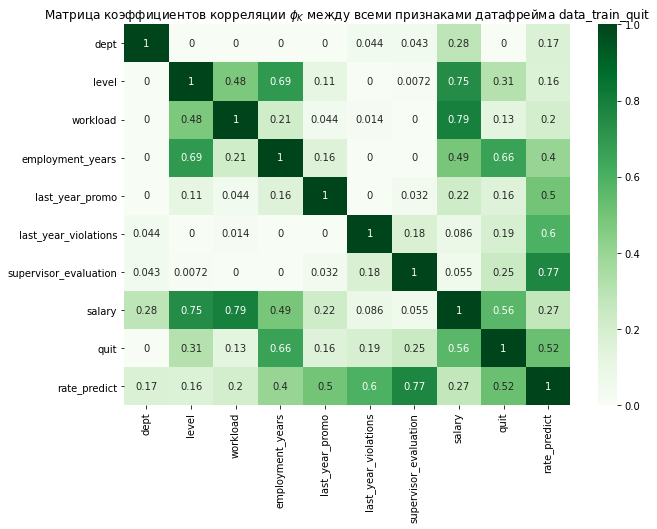

In [87]:
interval_cols_quit = [
    'salary',
    'rate_predict'
]

plt.figure(figsize = (10,7))
sns.heatmap(data_train_quit.iloc[:,1:].phik_matrix(interval_cols=interval_cols_quit), annot=True, cmap='Greens')
plt.title(r'Матрица коэффициентов корреляции $\phi_K$ между всеми признаками датафрейма data_train_quit')
plt.show()

**Полученная матрица корреляции позволяет сделать следующие выводы:**
- между входными признаками нет мультиколлинеарности
- больше всего целевой признак `quit` коррелирует со следующими входными признаками:
   - заметная корреляция с признаком  `employment_years` - коэффициент корреляции 0.66
   - заметная корреляция с признаком `salary` - коэффициент корреляции 0.56
- входной признак `salary` имеет высокую связь с входными признаками `workload` и `level`.
- межуд целевым признаком `quit` и входным `dept` отсутствует взаимосвязь, при построении модели нужно будет изучить влияние признаков на принятие решений моделью и в случае подтверждения отсутствия важности у признака `dept` исключить его для увеличения качества модели 

### Подготовка данных

#### Объединение таблиц

Хоть об этом не было сказано в задании, но думаю будет удобно сразу объединить тестовую выборку `data_x_test_quit` с реальными значениями уволившихся/оставшихся сотрудников `data_y_test_quit`, чтобы не было путаницы при получении прогнозов и оценивания метрик модели, так как мы видели, что порядок строк отличается в тестовом датафрейме и в датафрейме с тестовыми значениями для столбца `quit`. Применим метод `merge`, указав в стобце для объединения `id` и проверим, что при объединении не образовалось новых пропусков.

In [88]:
data_test_quit = data_x_test_quit.merge(data_y_test_quit, how = 'left',on = 'id')
data_test_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,rate_predict,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.844000,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.672727,no
2,467458,sales,middle,low,5,no,no,4,19200,0.654000,no
3,418655,sales,middle,low,6,no,no,4,19200,0.655000,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.816429,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.544000,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.152000,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.240000,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.533333,no


Проверим, что не образовалось новых пропусков

In [89]:
data_test_quit.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
rate_predict             0
quit                     0
dtype: int64

Новых пропусков в столбце `quit` не образовалось

**Таблицы `data_x_test_quit` и `data_y_test_quit` объединены в датафрейм `data_test_quit`. Отметки об уволившихся/оставшихся сотрудниках корректно проставились к каждому `id`**

#### Подготовка данных при помощи ColumnTransformer

Так как входные признаки у нас точно такие же, за исключением нового целевого признака `quit` и добавления в качестве входного признака прогнозных значений целевого признака из прошлого этапа работы `rate_predict`, то основные положения по подготовке признаков остались такие же, а именно:
- так как мы будем использовать линейную модель, то для нее важно задать порядок значений в признаках, которые поддаются ранжированию, для них будем использовать OrdinalEncoder(). Поэтому к признакам `level`, `workload`, `last_year_promo`, `last_year_violations` будем применять `OrdinalEncoder()`
- признак `dept`, который номинальный и ранжированию не поддается, будем кодировать при помощи OneHotEncdoder() (хоть признак `dept` и имеет 5 уникальных значений, а значит при кодировании в OHE и при применении параметра `drop=first` создастся 4 новых столбца, что не пойдет на пользу нелинейным моделям, но у нас также есть и линейная модель классификации, которая может найти взаимосвязи там где их нет, если мы передадим столбец с профессиями в OrdinalEncoder(). Поэтому хоть мы и создадим 4 новых признака, что не пойдет на пользу нелинейной модели, но зато не запутает линейную.)
- так как у нас есть явные и неявные пропуски в категориальных столбцах, то при использовании кодировщиков OneHotEncoder() и OrdinalEncoder() нужно использовать обработку пропусков и замену их на моды.
- количественные признаки будем масштабировать изначально при помощи `StandardScaler()`, потом через словарь с гиперпараметрами добавим еще `MinMaxScaler()`.

**Разделение признаков на порядковые и номинальные будет следующим:**
 - `dept` нельзя проранжировать, поэтому его будем кодировать при помощи OneHotEncoder()
 - `level`, `workload`, `last_year_promo`, `last_year_violations` можно проранжировать, поэтому для них создадим словарь `categories` и будем кодировать при помощи `OrdinalEncoder()`.
 
 Целевой признак имеет всего два значения, поэтому LaberEncoder() к нему для ускорения вычислений применять не будем в пайплайне

Для начала создадим отдельные списки для столбцов, которые будут масштабироваться и кодироваться разными способами.

In [90]:
ohe_columns_quit = [
    'dept'
]

ord_columns_quit = [
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations'
]

num_columns_quit = ['employment_years',
               'supervisor_evaluation',
               'salary',
                'rate_predict'] 

Повторяю текст по использованию `train_test_split`, который писал на предыдущем этапе выполнения работы:

так как в нашем исследовании есть отложенная тестовая выборка, которую нам предоставили для окончательной оценки работы модели, а валидацию модели мы производить не будем на отдельной валидационной выборке, так как лучшие значения гиперпараметров будут подбираться автоматизированным путем при помощи GridSearch(), а метрика считаться кросс-валидацией, то не будем использовать `train_test_split` и делить тренировочный датасет на тренировочную выборку и валидационную. Поэтому просто присвоим переменным `X_train` и `y_train` верные столбцы со значениями.

In [91]:
#объявляем константы
RANDOM_STATE = 42

X_train_quit = data_train_quit.drop(['id', 'quit'], axis=1)
y_train_quit = data_train_quit['quit']
X_test_quit = data_test_quit.drop(['id','quit'], axis=1)
y_test_quit = data_test_quit['quit']

Как и на первом этапе работы, создаем пайплайн для предобрабоки данных с заменой пропусков на моду. Не забываем создать `categories`, чтобы передать его в Ordinal encoder с указанием всех ранжированных признаков

In [92]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков (хоть в данном случае у нас их нет,
#но оставим сразу для использования в будущем) и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OHE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle','senior'], 
                    ['low', 'medium','high'],
                    ['no','yes'],
                    ['no','yes']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_quit = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_quit),
        ('ord', ord_pipe, ord_columns_quit),
        ('num', StandardScaler(), num_columns_quit)
    ], 
    remainder='passthrough'
)
print(data_preprocessor_quit)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(cat...
                                                          

**Создан пайплайн `data_preprocessor_quit` для подготовки данных**

**На этапе подготовки данных были проделаны следующие действия:**
- таблицы `data_x_test_quit` и `data_y_test_quit` объединены в датафрейм `data_test_quit`. Отметки о том, уволился сотрудник или нет, корректно проставились к каждому объекту
- создан пайплайн `data_preprocessor_quit` для подготовки всех данных

### Обучение моделей

Для обучения будем использовать несколько моделей классификации: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression() и SVC(). Создадим общий список со словарями с гиперпараметрами для всех моделей, указав в нем в качестве нескольких вариантов масштабирования StandardScaler() и  MinMaxScaler(), вариант без масштабирования `passthrough` рассматривать не будем. В качестве метрики будем использовать ROC-AUC, так как она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения и не зависит от того, какой порог мы выберем, поэтому является самой общей оценкой итогов работы модели.

#### Создание словаря с  гиперпараметрами для моделей и масштабирования

Для начала возьмем небольшие диапазоны гиперпараметров для моделей. У модели SVC оставим только нелинейное ядро `rbf` и гиперпараметр `C`, так как если указать остальные ядра и гамму со своими диапазонами значений, то время расчетов сильно увеличивается. У модели SVC указываем параметр `probability = True` для работы с вероятностями. Так как у модели логистической регрессии аглоритм `lbfgs`, использующийся по умолчанию, не работает вместе с `l2` регуляризацией, то укажем алгоритмы для нахождения параметров  `saga` и `liblinear`, последний также подходит для небольшого набора данных

In [93]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__min_samples_split' : range(2,6),
        'models__min_samples_leaf' : range(1,3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE 
        )],
        'models__C': range(1,5),
        'models__solver': ['liblinear', 'saga'],
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    #оставил только нелинейное ядро rbf и не использовал гамму, так как  при указании нескольких разных ядер расчеты становятся бесконечными
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

**Получился итоговый список словарей с гиперпараметрами для моделей**

#### Создание итогового пайплайна

Теперь объединим все в итоговый пайплайн, так как  моделей много и у всех есть диапазоны гиперпараметров, то сразу будем использовать RandomizedSearchCV(), сначала с количеством итераций по умолчанию 10.

In [94]:
pipe_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__min_samples_split' : range(2,6),
        'models__min_samples_leaf' : range(1,3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,14),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': range(1,5),
        'models__solver': ['liblinear', 'saga'],
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    #оставил только нелинейное ядро rbf и не использовал гамму, так как  при указании нескольких разных ядер расчеты становятся бесконечными
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

randomized_search_quit = RandomizedSearchCV(
    pipe_quit, 
    param_distributions=param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 10
    n_iter=10
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

randomized_search_quit_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_quit_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search_quit.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 4.803458213806152
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                       

Метрика ROC-AUC на кросс-валидации показывает неплохой результат, попробуем еще немного его улучшить:
- добавим у дерева решений дополнительный гиперпараметр 'models__max_features': range(2,9)
- увеличим диапазоны остальных гиперпараметров у дерева решений
- немного увеличим количество соседей у kNN

In [95]:
pipe_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': range(1,5),
        'models__solver': ['liblinear', 'saga'],
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    #оставил только нелинейное ядро rbf и не использовал гамму, так как  при указании нескольких разных ядер расчеты становятся бесконечными
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

randomized_search_quit = RandomizedSearchCV(
    pipe_quit, 
    param_distributions=param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 10
    n_iter=10
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

randomized_search_quit_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_quit_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search_quit.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 2.080211877822876
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                       

Время подбора составило всего 2 секунды, но метрика ухудшилась, при увеличенных диапазонах гиперпараметров во время рандномизированного поиска кол-во итераций 10 слишком мало для нахождения более лучшего набора гиперпараметров, увеличим до 100

In [96]:
pipe_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': range(1,5),
        'models__solver': ['liblinear', 'saga'],
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    #оставил только нелинейное ядро rbf и не использовал гамму, так как  при указании нескольких разных ядер расчеты становятся бесконечными
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

randomized_search_quit = RandomizedSearchCV(
    pipe_quit, 
    param_distributions=param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 100
    n_iter=100
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

randomized_search_quit_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_quit_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search_quit.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 24.103891849517822
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                      

Метрика немного улучшилась, увеличим до 300 количество итераций

In [97]:
pipe_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,16),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,6),
        'models__max_features': range(2,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE
        )],
        'models__C': range(1,5),
        'models__solver': ['liblinear', 'saga'],
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    # словарь для модели SVC()
    #для получения меток вероятностей для подсчета в метрике ROC-AUC используем параметр probability = True
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

randomized_search_quit = RandomizedSearchCV(
    pipe_quit, 
    param_distributions=param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 300
    n_iter=300
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

randomized_search_quit_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_quit_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search_quit.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 65.69660425186157
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                       

Метрика еще немного увеличилась, на 0.002 по сравнению с предыдущим результатом, но время подбора сильно увеличилось.

Попробуем еще улучшить нашу метрику:
- у самых лучших моделей параметр `max_depth` не превышает 9, поэтому уменьшим его с 16 до 11
- параметр `min_samples_leaf` наоборот увеличим до 9
- уберем из подбираемых моделей LogisticRegression()

In [98]:
pipe_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,11),
        'models__min_samples_split' : range(2,8),
        'models__min_samples_leaf' : range(1,9),
        'models__max_features': range(2,8),
        'preprocessor__num': [StandardScaler(),MinMaxScaler()]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(probability = True,
            random_state=RANDOM_STATE
        )],
        'models__kernel':['rbf'],
        'models__C': range(1,4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

start = time.time()

randomized_search_quit = RandomizedSearchCV(
    pipe_quit, 
    param_distributions=param_grid_quit, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
#количество итераций задаем 300
    n_iter=300
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

randomized_search_quit_time = time.time() - start
print('Характеристики при RandomizedSearchCV')
print(f'Время подбора гиперпараметров для моделей: {randomized_search_quit_time}')


print('Лучшая модель и её параметры:\n\n', randomized_search_quit.best_estimator_)
print ('Метрика ROC-AUC для лучшей модели, полученная при кросс-валидации:', randomized_search_quit.best_score_)

Характеристики при RandomizedSearchCV
Время подбора гиперпараметров для моделей: 64.16270542144775
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept']),
                                                 ('ord',
                       

Получено лучшее значение метрики. Время подбора составило 63 секунды, значение ROC-AUC при кросс-валидации составило 0.9324886274404655

Дополнительно посмотрим таблицу cv_results_ для изучения всех лучших моделей, их параметров и методов масштабирования

In [99]:
randomized_search_quit.cv_results_

#получаем таблицу с работой всех моделей
result_models_quit = pd.DataFrame(randomized_search_quit.cv_results_)

#отображаем нужные столбцы и выводим для наглядности первые 5 лучших моделей
display(result_models_quit[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(5) )

,rank_test_score,param_models,mean_test_score,params
179,1,DecisionTreeClassifier(random_state=42),0.932489,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 7, 'models__max_features': 7, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
213,2,DecisionTreeClassifier(random_state=42),0.930306,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 7, 'models__max_features': 7, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
31,3,DecisionTreeClassifier(random_state=42),0.929887,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 2, 'models__min_samples_leaf': 7, 'models__max_features': 7, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
88,3,DecisionTreeClassifier(random_state=42),0.929887,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 3, 'models__min_samples_leaf': 7, 'models__max_features': 7, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
297,5,DecisionTreeClassifier(random_state=42),0.929572,"{'preprocessor__num': StandardScaler(), 'models__min_samples_split': 5, 'models__min_samples_leaf': 8, 'models__max_features': 7, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"


Все лучшие модели оказались DecisionTreeClassifier().

**Во время автоматизированного подбора гиперпараметров для модели в итоговом пайплайне  было получено следующее:**
- при увеличении диапазонов рассматриваемых гиперпараметров и увеличении количества итераций при рандомизированном поиске значение метрики ROC-AUC на кросс-валидации увеличивалось
- **лучшей моделью стала модель DecisionTreeClassifier (max_depth=9, max_features=7, min_samples_leaf=7, min_samples_split=5, random_state=42), метод масштабирования StandardScaler().**
- метрика ROC-AUC у лучшей модели  при кросс-валидации составила 0.932

#### Отбор наименее важных признаков

Более глубокий анализ признаков при помощи SHAP рассмотрим в следующем пункте, чтобы составить более направленные рекомендации заказчику. Сейчас посмотрим на коэффициенты важности признаков, которые модель рассчитала для каждого входного признака. В нашей лучшей модели DecisionTreeClassifier() для отображения важности признаков воспользуемся `feature_importances_`. Создадим датафрейм с наименованиями

In [100]:
#создаем датафрейм для значений важности и наименований каждого столбца, данные берем из пайплайна с лучшей обученной моделью
feature_importances_tree = pd.DataFrame(
    {
        'Feature': randomized_search_quit.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
        'Importance': round(pd.Series(randomized_search_quit.best_estimator_.named_steps['models'].feature_importances_),3)
    })

Визуализируем график важности признаков

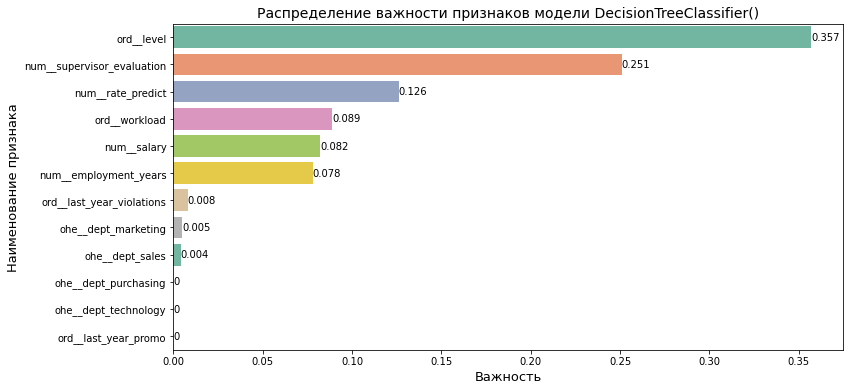

In [101]:
#рисуем график важности признаков
plt.figure(figsize=(12, 6))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = feature_importances_tree.sort_values(by='Importance', ascending = False), palette = 'Set2')
#указываем значения на каждой оси
for i in ax.containers:
    ax.bar_label(i,)
plt.xlabel('Важность', fontsize = 13)
plt.ylabel('Наименование признака', fontsize = 13)
plt.title('Распределение важности признаков модели DecisionTreeClassifier()', fontsize = 14)
plt.show()

Полученный график показывает, что коэффициенты менее 0.02 имеют признаки `last_year_promo`, `dept` и `last_year_violations`, попробуем удалить их и посмотрим на изменение метрики

Для этого создадим новый пайплайн `pipe_few`, включающий предобработку данных и объявленную модель с лучшими гиперпараметрами. Для этого из предыдущего пайплайна уберем наименее важные признаки, также изменим список `categories` для OrdinalEncoder(), также уберем OHE кодирование, так как единственный столбец, который там был, мы тоже удаляем, также создадим новые тренировочный и тестовые выборки, состоящие из целых датасетов без наименее важных признаков

In [102]:
#списки для кодировщика и скейлера
ord_columns_few = [
    'level',
    'workload'
]

num_columns_few = ['employment_years',
               'supervisor_evaluation',
               'salary',
                'rate_predict'] 

#новые тренировочные и тестовые датасеты
X_train_few = data_train_quit.drop(['id', 'quit','last_year_promo','last_year_violations','dept'], axis=1)
y_train_few = data_train_quit['quit']
X_test_few = data_test_quit.drop(['id','quit','last_year_promo','last_year_violations','dept'], axis=1)
y_test_few = data_test_quit['quit']


# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OHE
ord_pipe_few = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle','senior'], 
                    ['low', 'medium','high']
                ],
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor_few = ColumnTransformer(
    [
        ('ord', ord_pipe_few, ord_columns_few),
        ('num', MinMaxScaler(), num_columns_few)
    ], 
    remainder='passthrough'
)


Следующим действием нужно объявить новый окончательный пайплан и посмотреть метрику на кросс-валидации. Так как мы смотрели важность признаков именно лучшей модели, которая использовала определенный набор подобранных гиперпараметров, поэтому и после отбора признаков нам необходимо смотреть метрику именно для этой же модели с таким же набором значений гиперпараметров, так как при другом наборе значений гиперпараметров и важность у разных признаков могла поменяться.  Поэтому в пайплайне оставил только эту одну модель.Так как нам не нужно пользоваться автоматизированным подбором гиперпараметров сейчас, а метрику нужно считать также кросс-валидацией, то посчитаем ее сами, воспользовавшись `cross_val_score`.

In [103]:
pipe_few = Pipeline([
    ('preprocessor', data_preprocessor_few),
    ('models', DecisionTreeClassifier(max_depth=9, 
                                      max_features=7, 
                                      min_samples_leaf=7, 
                                      min_samples_split=5,
                                      random_state=RANDOM_STATE))
])
    
score = cross_val_score(
    pipe_few,
    X_train_few,
    y_train_few,
    scoring = 'roc_auc',
    n_jobs= -1).mean()
print(f'Метрика ROC-AUC, посчитанная при кросс-валидации {score}')

Метрика ROC-AUC, посчитанная при кросс-валидации 0.9252510241334371


*Метрика на кросс-валидации с убранными наименее важными признаками получилась меньше на 0.008, чем при полном наборе признаков, значит, оставим полный набор признаков.*

#### Результаты на тестовой выборке

Теперь попробуем получить прогнозные значения на тестовой выборке.

In [104]:
# проверяем работу лучшей модели на тестовой выборке
# рассчитываем прогнозные метки на тестовых данных
y_test_quit_proba = randomized_search_quit.best_estimator_.predict_proba(X_test_quit)[:,1]
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: {roc_auc_score(y_test_quit, y_test_quit_proba)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9197929631166163


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Появилось предупреждение о том, что некоторые данные в столбцах пропущены и во время кодировки будут преобразованы в нулевую категорию. Это правило мы устанавливали в кодировщике OHE, на этапе предобработки мы видели эти пропуски.

Метрика показала результат немногим меньше результата на кросс-валидации, значит, у модели небольшой разброс, а так как модель показала высокий результат на кросс-валидации, то у лучшей полученной модели также невысокое смещение.

Осталось проверить модель на "адекватность", сравнив ее результаты с результатами работы модели `DummyClassifier`

#### Проверка модели на адекватность

Так как метрика ROC-AUC константной модели DummyClassifier() всегда 0.5, то наша лучшая модель справилась с проверкой на адекватность и показывает метрику намного выше.

#### Анализ признаков и рекомендации

Для того, чтобы составить более подробные рекомендации заказчику, посмотрим на графики важности признаков модели при помощи SHAP для нашей лучшей модели

Подготоваливаем данные для передачи в TreeExplainer:

In [111]:
X_test_transform = pd.DataFrame(
    randomized_search_quit.best_estimator_.named_steps['preprocessor'].transform(X_test_quit),
    columns = randomized_search_quit.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Считаем значения SHAP

In [112]:
explainer=shap.TreeExplainer(randomized_search_quit.best_estimator_.named_steps['models'],X_test_transform)
shap_values = explainer(X_test_transform)

#для корректного отображения на графике берем только метки положительного класса
shap_values = shap_values[...,1]

Строим графики столбчатой диаграммы и пчелиного роя

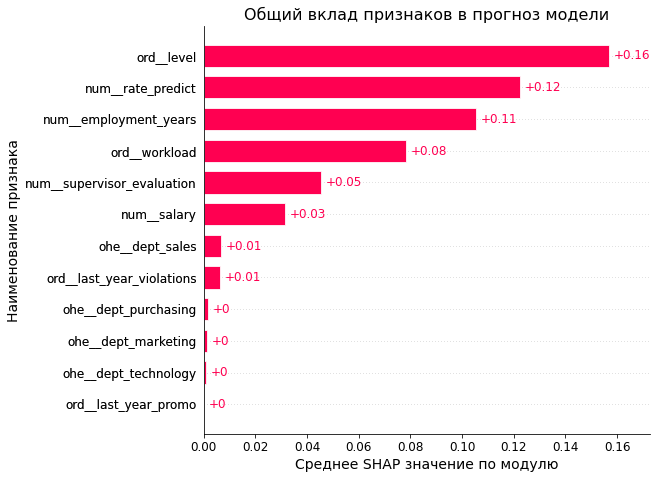

In [113]:
#объявляем график до подписания осей и установки размеров и указываем show=False, 
#чтобы можно дополнительно было настроить график после его создания.
shap.plots.bar(shap_values, max_display = None,show=False)

#объявляем фигуру и объекты осей
fig, ax = plt.gcf(), plt.gca()

#размер наименования подписи каждого признака
ax.tick_params(labelsize=12)

#подписи осей и наименования графика
ax.set_ylabel("Наименование признака", fontsize=14)
ax.set_xlabel("Среднее SHAP значение по модулю", fontsize=14)
ax.set_title('Общий вклад признаков в прогноз модели', fontsize=16)

#отображение конечного графика
plt.show()

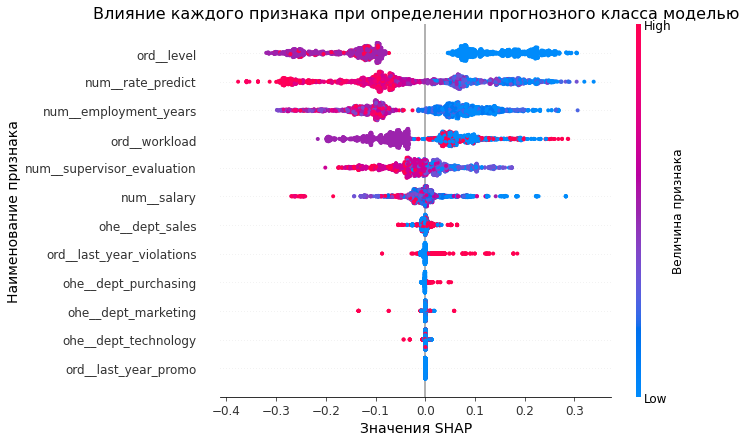

In [114]:
#объявляем график до подписания осей и установки размеров и указываем show=False, 
#чтобы можно дополнительно было настроить график после его создания.
#параметром plot_size расстягиваем значения по ширине, чтобы они были не узкие
shap.summary_plot(shap_values, show=False, plot_size=[10,6])

#объявляем фигуру и объекты осей
fig, ax = plt.gcf(), plt.gca()

#размер наименования подписи каждого признака
ax.tick_params(labelsize=12)

#подписи осей и наименования графика
ax.set_xlabel("Значения SHAP", fontsize=14)
ax.set_ylabel("Наименование признака", fontsize=14)
ax.set_title('Влияние каждого признака при определении прогнозного класса моделью', fontsize=16)

# Установить размер для величин high и low 
fig.axes[1].tick_params(labelsize=12)
#установить размер подписи цветовой шкалы
fig.axes[1].set_ylabel("Величина признака", fontsize=12)

#отображение конечного графика
plt.show()

**График значений SHAP показал следующее:**
 - признаки, которые больше всего влияют на то, останется сотрудник в компании или уволится:
   - квалификация сотрудника
   - количество отработанных лет
   - оценка удовлетворенностью работой
 - признаки, которые меньше всего влияют на то, останется сотрудник в компаниии или уволится:
   - отдел, в котором работает сотрудник
   - повышение за прошлый год
   - факт нарушения сотрудником трудового договора за последний год

**Учитывая, что класс 0 - это оставшиеся сотрудники в компании, а 1 - уволившиеся сотрудники из компании, график пчелиного роя позволяет сделать следующие выводы:**

- при увеличеним квалификации сотрудника повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- при увеличении количества отработанных лет также повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- высокий уровень загруженности сотрудника сильно повышает вероятность отнесения такого сотрудника к числу уволившихся из компании, при низком уровне загруженности модель также относит с таких сотрудников к числу уволившихся из компании, но с меньшей вероятностью. При среднем уровне загруженности повышается вероятность отнесения моделью такого сотрудника к числу оставшихся в компании
- при увеличении оценки удовлетворенности повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании
- при увеличении заработной платы также повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании

**Рекомендации для бизнеса могут быть следующими:**

- так как график важности признаков показал, что с увеличением срока работы в компании уменьшается вероятность увольнения сотрудника, то необходимо добавить дополнительную систему поощрения сотрудников, долго работающих в компании, это может быть как денежные выплаты, так и дополнително предоставляемые дни отпуска или дополнительные награды
- также график показал, что больше всего вероятность увольнения сотрудников с максимальным уровнем загруженности и минимальным. Необходимо более тщательно следить со стороны руководителя, чтобы нагрузка среди подчиненных была более сбалансирована, так как у сотрудников со средней нагрузкой больше всего вероятность остаться в компании. 
- необходимо создавать условия для развития и повышения квалификации сотрудников, проводить внутренние тренинги или записывать сотрудников на курсы для повышения квалификации, так как график признаков показал, что при повышении квалификации снижается вероятность увольнения сотрудников
- необходимо стараться увеличивать оценку удовлетворенности. Действия по улучшению условий труда и атмосферы в коллективе должны быть направлены на то, чтобы оценка сотрудника была больше 0.4, атмосфера в коллективе должна быть дружелюбной и комфортной, необходимо проводить мероприятия для укрепления командного духа
- стратегия должна быть направлена на увеличение объема работы сотрудников, которые имеют низкий уровень загруженности, вследствие этого низкий уровень зарплаты и низкие оценки удовлетворенности. Увеличение нагрузки сотрудника должно более существенно поощряться в разнице окладов, так как при повышении менее 5000 риск увольнения такого сотрудника повышается
-  быть более внимательным к сотрудникам, чья оценка удовлетворенности составляет ниже 0.4, стараться увеличить их уровень нагруженности и вовлеченности с достойным увеличением заработной платы
- стараться быть более внимательным к сотрудникам, подходящим под портрет `уволившегося сотрудника`, стараться создавать большую нагрузку для таких работников с увеличением заработной платы не менее определенной суммы для каждого уровня квалификации сотрудника (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000)
- продолжать регулярно проводить анкетирование по оценкам удовлетворенности, можно внедрить дополнительные вопросы насчет мотивации сотрудников
-  при занесении данных исправить уровень квалификации `sinior` на `senior`.

#### Результаты обучения моделей

**При составлении пайплайна для подбора гиперпараметров сразу нескольким моделям были проделаны следующие шаги и получены следующие результаты**
- создан итоговый пайплайн, включающий:
  - подготовку данных:
   - использование двух методов кодирования категориальных признаков: при помощи OneHotEncoder() и OrdinalEncoder()
   - использование двух вариантов масштабирования количественных признаков: MinMaxScaler(), StandardScaler()
   - перебор моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() с их гиперпараметрами при помощи инструмента автоматизированного подбора GridSearchCV() и RandomizedSearchCV().
- для оценивания качества получаемых моделей была выбрана метрика ROC-AUC, так как она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения и не зависит от того, какой порог мы выберем и поэтому является самой общей оценкой итогов работы модели
- при помощи инструмента автоматизированного подбора гиперпараметров RandomizedSearchCV() для моделей  были получены следующие результаты:
  - при увеличении диапазонов рассматриваемых гиперпараметров и увеличении количества итераций при рандомизированном поиске значение метрики ROC-AUC на кросс-валидации увеличивалось
  - лучшая модель была подобрана за 65 секунд.
  - метрика ROC-AUC составила:
    - при кросс-валидации 0.932
    - на тестовом набобре данных 0.919
- **лучшей моделью оказалась модель DecisionTreeClassifier (max_depth=9, max_features=7, min_samples_leaf=7, min_samples_split=5, random_state=42), метод масштабирования StandardScaler(), также она прошла проверку на адекватность и показала метрики намного выше, чем у константной модели**

*При попытке убрать наименее важные признаки метрика лучшей модели при кросс-валидации уменьшилась, поэтому был оставлен полный набор признаков.*

**График значений SHAP показал следующее:**
 - признаки, которые больше всего влияют на то, останется сотрудник в компаниии или уволится:
   - квалификация сотрудника
   - количество отработанных лет
   - оценка удовлетворенностью работой
 - признаки, которые меньше всего влияют на то, останется сотрудник в компаниии или уволится:
   - отдел, в котором работает сотрудник
   - повышение за прошлый год
   - факт нарушения сотрудником трудового договора за последний год

**Учитывая, что класс 0 - это оставшиеся сотрудники в компании, а 1 - уволившиеся сотрудники из компании, график пчелиного роя позволяет сделать следующие выводы:**

- при увеличеним квалификации сотрудника повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- при увеличении количества отработанных лет также повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- высокий уровень загруженности сотрудника сильно повышает вероятность отнесения такого сотрудника к числу уволившихся из компании, при низком уровне загруженности модель также относит с таких сотрудников к числу уволившихся из компании, но с меньшей вероятностью. При среднем уровне загруженности повышается вероятность отнесения моделью такого сотрудника к числу оставшихся в компании
- при увеличении оценки удовлетворенности повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании
- при увеличении заработной платы также повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании

**Рекомендации для бизнеса могут быть следующими:**

- так как график важности признаков показал, что с увеличением срока работы в компании уменьшается вероятность увольнения сотрудника, то необходимо добавить дополнительную систему поощрения сотрудников, долго работающих в компании, это может быть как денежные выплаты, так и дополнително предоставляемые дни отпуска или дополнительные награды
- также график показал, что больше всего вероятность увольнения сотрудников с максимальным уровнем загруженности и минимальным. Необходимо более тщательно следить со стороны руководителя, чтобы нагрузка среди подчиненных была более сбалансирована, так как у сотрудников со средней нагрузкой больше всего вероятность остаться в компании. 
- необходимо создавать условия для развития и повышения квалификации сотрудников, проводить внутренние тренинги или записывать сотрудников на курсы для повышения квалификации, так как график признаков показал, что при повышении квалификации снижается вероятность увольнения сотрудников
- необходимо стараться увеличивать оценку удовлетворенности. Действия по улучшению условий труда и атмосферы в коллективе должны быть направлены на то, чтобы оценка сотрудника была больше 0.4, атмосфера в коллективе должна быть дружелюбной и комфортной, необходимо проводить мероприятия для укрепления командного духа
- стратегия должна быть направлена на увеличение объема работы сотрудников, которые имеют низкий уровень загруженности, вследствие этого низкий уровень зарплаты и низкие оценки удовлетворенности. Увеличение нагрузки сотрудника должно более существенно поощряться в разнице окладов, так как при повышении менее 5000 риск увольнения такого сотрудника повышается
-  быть более внимательным к сотрудникам, чья оценка удовлетворенности составляет ниже 0.4, стараться увеличить их уровень нагруженности и вовлеченности с достойным увеличением заработной платы
- стараться быть более внимательным к сотрудникам, подходящим под портрет `уволившегося сотрудника`, стараться создавать большую нагрузку для таких работников с увеличением заработной платы не менее определенной суммы для каждого уровня квалификации сотрудника (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000)
- продолжать регулярно проводить анкетирование по оценкам удовлетворенности, можно внедрить дополнительные вопросы насчет мотивации сотрудников
-  при занесении данных исправить уровень квалификации `sinior` на `senior`.

## Итоговые выводы

Наше исследование было разделено на два этапа, каждый включал определенную последовательность действий и результатов, последовательно перечислим основные выводы по каждому этапу нашего исследования.

**На первом этапе нашего исследования мы рассматривали уровень удовлетворённости сотрудников:**

**На этапе предобработки данных были выполнены следующие действия:**
- столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.
- столбцы с должностью `dept` и уровнем квалификации `level` имеют явные пропуски в тренировочном и тестовом датафреймах. Найденные пропуски в категориальных столбцах оставлены как есть, при кодировании будет добавлена обработка пропусков.
- явных аномальных значений в данных не обнаружено.
- типы данных столбцов соответствуют значениям в них
- во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test`, которые в дальнейшем были обработаны в пайплайне во время кодирования значений.

**На этапе исследовательского анализа были получены следующие результаты:**

**Полученные графики для количественных признаков показывают следующее:**
- распределения на тренировочном датасете и на тестовом для количественных признаков очень схожи, соблюдены пропорции каждого из признаков, похоже, что один общий датасет разделили на тренировочный и тестовый, указав в стратификации все признаки
- кол-во отработанных лет имеет диапазон значений от 1 до 10 лет. Самое частое значение - 1 год и частота встречаемости плавно уменьшается к 10 годам
- самые частые оценки руководителя - 4 и 3, значит большинство сотрудников выполяют свои должностные обязанности
- медианное значение зарплаты - 30000, всего 25% сотрудников получают зарплату выше 43200, при корреляции посмотрим  как это влияет на удовлетворенность сотрудников.
- график распределения удовлетворенности сотрудников похож на нормальное распределение со смещением в диапазон 0.7 для самых часто встречающихся значений, медианные же значения находятся в дипазоне 0.56 для тренировочного датасета и 0.58 для тестового датасета

**Полученные графики для категориальных признаков позволяют сделать следующие выводы:**
- распределения долей на тренировочном датасете и на тестовом в категориальных признаках также очень схожи, как и у количественных признаков
- по количеству сотрудников на разных должностях распределения долей в тренировочном и тестовом датафрейме получилось следующим:
  - `sales` - 37.9% на тренировочном и 38.2% на тестовом
  - `technology` - 21.7% на тренировочном и 22.8% на тестовом
  - `purchasing` - 15.3% на тренировочном и 14% на тестовом
  - `marketing` - 13.8% на тренировочном и 13.7% на тестовом
  - `hr` - 11.4% на тренировочном и 11.4% на тестовом
- по уровню квалицикации доли сотрудников распределяются следующим образом:
  - `junior` - 47.4.9% на тренировочном и 48.7% на тестовом
  - `middle` - 43.6% на тренировочном и 42.7% на тестовом
  - `senior` - 9% на тренировочном и 8.6% на тестовом
- по загруженности больше всего средняя оценка загруженности `medium` - 51.6% на тренировочном и 52.1% на тестовом датафрейме
- у подавляющего большинства сотрудников не было повышений за прошлый год - 97% на тренировочном и 96.9% на тестовом датафрейме
- у большинства сотрудников не было выявленных нарушений за прошлый год - 86% на тренировочном и 86.9% на тестовом датафрейме

**На этапе корреляционного анализа полученные матрицы корреляции позволили сделать следующие выводы:**
- между входными признаками нет мультиколлинеарности
- больше всего целевой признак `job_satisfaction_rate` коррелирует со следующими входными признаками:
   - высокая корреляции с признаком  `supervisor_evaluation` - коэффициент корреляции 0.73
   - заметная корреляции с признаком `last_year_violations` - коэффициент корреляции 0.59
- входной признак `salary` имеет высокую связь с входными признаками `workload` и `level`.

**На этапе подготовки данных были проделаны следующие действия:**
- таблицы `data_x_test` и `data_y_test_rate` объединены в датафрейм `data_test_rate`. Оценки удовлетворенности сотрудников корректно проставились к каждому объекту
- создан пайплайн `data_preprocessor` для подготовки всех данных

**На этапе подбора лучшей модели были проделаны следующие шаги и получены следующие результаты**
- создан итоговый пайплайн, включающий:
  - подготовку данных:
   - использование двух методов кодирования категориальных признаков: при помощи OneHotEncoder() и OrdinalEncoder()
   - использование нескольких вариантов масштабирования количественных признаков: MinMaxScaler(), StandardScaler() и вариант без маштабирования
   - перебор моделей DecisionTreeRegressor() и LinearRegression() с со словарями их гиперпараметров при помощи инструментов автоматизированного подбора GridSearchCV() и RandomizedSearchCV().
- для оценивания качества работы моделей была созданна собственная метрика SMAPE, которая при помощи make_scorer была применена при автоматизированном поиске гиперпараметров
- при помощи инструмента автоматизированного подбора гиперпараметров RandomizedSearchCV() для моделей  были получены следующие результаты:
  - **лучшей моделью оказалась модель DecisionTreeRegressor(max_depth=15, max_features=7, min_samples_leaf=1, min_samples_split=7, random_state=42), метод масштабирования MinMaxScaler()**
  - лучшая модель была подобрана за 13.8 секунды.
  - метрика SMAPE составила:
    - при кросс-валидации 15.5
    - на тестовом набобре данных 13.9
    
При анализе важности признаков оказалось, что прогнозируемая моделью величина оценки удовлетворенности:
- больше всего зависит от оценки непосредственного руководителя
- меньше всего зависит от отдела, в котором работает сотрудник 
    
**На втором этапе нашего исследования мы рассматривали отток сотрудников из компании:**

**На этапе предобработки данных были выполнены следующие действия и получены следующие результаты:**
- столбцы изначально были приведены к змеиному регистру, лишних пробелов не обнаружено. Наименования столбцов и порядок в тренировочном датафрейме и тестовом идентичны.
- столбцы с должностью `dept` и уровнем квалификации `level` имеют явные пропуски в тестовом датафрейме `data_x_test_quit`. Найденные пропуски в категориальных столбцах оставлены как есть и при кодировании нужно добавить обработку пропусков.
- явных аномальных значений в данных не обнаружено.
- типы данных столбцов соответствуют значениям в них
- во время проверки явных и неявных дубликатов обнаружено не было, некорректное значение в категориальном столбце `level` было устранено. Также были обнаружены неявные пропуски в столбцах `dept` и `workload` датафрейма с тестовыми данными `data_x_test_quit`, которые будут обработаны в пайплайне во время кодирования значений.

**На этапе исследовательского анализа были получены следующие результаты:**

**Полученные графики для количественных признаков повторяют точно такие же выводы, как и на первом этапе работы:**
- распределения на тренировочном датасете и на тестовом для количественных признаков очень схожи, соблюдены пропорции каждого из признаков, похоже, что один общий датасет разделили на тренировочный и тестовый, указав в стратификации все признаки
- кол-во отработанных лет имеет диапазон значений от 1 до 10 лет. Самое частое значение - 1 год и частота встречаемости плавно уменьшается к 10 годам
- самые частые оценки руководителя - 4 и 3, значит большинство сотрудников выполяют свои должностные обязанности
- медианное значение зарплаты - 30000, всего 25% сотрудников получают зарплату выше 43200, при корреляции посмотрим  как это влияет на удовлетворенность сотрудников.

**Полученные графики для категориальных признаков позволяют сделать точно такие же выводы, как и на первом этапе работы:**
- распределения долей на тренировочном датасете и на тестовом в категориальных признаках также очень схожи, как и у количественных признаков
- по количеству сотрудников на разных должностях распределения долей в тренировочном и тестовом датафрейме получилось следующим:
  - `sales` - 35.9% на тренировочном и 38.2% на тестовом
  - `technology` - 23.2% на тренировочном и 22.8% на тестовом
  - `purchasing` - 14.7% на тренировочном и 13.7% на тестовом
  - `marketing` - 14.6% на тренировочном и 14% на тестовом
  - `hr` - 11.6% на тренировочном и 11.4% на тестовом
- по уровню квалицикации доли сотрудников распределяются следующим образом:
  - `junior` - 48.7% на тренировочном и 48.7% на тестовом
  - `middle` - 42.4% на тренировочном и 42.7% на тестовом
  - `senior` - 8.9% на тренировочном и 8.6% на тестовом
- по загруженности больше всего средняя оценка загруженности `medium` - 53% на тренировочном и 52.1% на тестовом датафрейме
- у подавляющего большинства сотрудников не было повышений за прошлый год - 97.2% на тренировочном и 96.9% на тестовом датафрейме
- у большинства сотрудников не было выявленных нарушений за прошлый год - 86.4% на тренировочном и 86.9% на тестовом датафрейме
- большинство сотрудников представлены из числа неуволившихся: 71.8% на тренировочном датафрейме и 71.8% на тестовой

**При составлении портрета «уволившегося сотрудника» полученные графики позволили сделать следующие выводы:**
 - доли уволившихся сотрудников во всех отделах не сильно отличаются
 - немного больше увольняется сотрудников из отдела `technology` (0.297 от общего количества сотрудников в отделе)
 - меньше всего увольняется сотрудников из отдела `hr` (0.25 от общего количества сотрудников в отделе)
 - по отношению кол-ва уволившихся сотрудников к общему кол-ву сотрудников наблюдается общая тенденция, что больше всего из отделов увольняются сотрудники с низкой нагрузкой `low`, если дополнительно рассматривать отделы, то рейтинг уволившихся будет следующим:
   - по соотношению числа уволившихся к общему числу сотрудников больше всего уволившихся в отделе продаж с низкой загрузкой, что логично, так как зачастую уровень заработка сотрудника в продажах зависит от количества этих самых продаж, а раз нет загруженности, то нет продаж
   - на втором месте по соотношению числа уволившихся к общему числу сотрудников находятся технологи с низкой загрузкой
   - на третьем месте по соотношению числа уволившихся к общему числу сотрудников находятся сотрудники отдела закупок с низкой нагрузкой
   
При рассмотрении заработных плат уволившихся/оставшихся в компании сотрудников получились следующие результаты:
 - медианное значение заработной платы всех оставшихся сотрудников в компании составляет 35000, что более чем на 10000 выше, чем у уволившихся сотрудников
 - диапазон самых распространенных значений зарплат (межквартильный размах) у всех оставшихся сотрудников выше более чем на 10000, чем у всех уволившихся сотрудников
 
При рассмотрении уровня квалификации сотрудников и их зарплат получились следующие результаты:
- разрыв между средним уровнем зарплат у уволившихся сотрудников и оставшихся в компании от начального уровня `junior` до `senior`  увеличивается по мере увеличения уровня квалификации:
  - зарплата оставшихся сотрудников уровня `junior` в среднем на 5000 больше, чем уволившихся такого же уровня
  -  зарплата оставшихся сотрудников уровня `middle` в среднем на 10000 больше, чем уволившихся такого же уровня
  - зарплата оставшихся сотрудников уровня `senior` в среднем на 12000 больше, чем уволившихся такого же уровня
  
При дополнительном рассмотрении уровня зарплат у сотрудников разных отделов и разной загруженности получились следующые выводы:
  - разрыв между медианным уровнем зарплат у уволившихся сотрудников и оставшихся в компании от низкой загруженности к более высокой увеличивается
 - уровень зарплат  увеличивается намного больше от уровня нагруженности у оставшихся сотрудников в компании, у уволившихся сотрудников зарплаты не сильно поднимались при рассмотрении более высокого уровня загруженности. 
 
**Исходя из вышеполученных результатов, портрет `уволившегося сотрудника`:**
 - это сотрудники с низким уровнем загруженности, преимущественно в отделе продаж и технологическом отделе с существенной разницей в уровне зарплаты между сотрудниками такой же квалификации (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000) и с небольшим увеличением в зарплате при работе на более высоком уровне загруженности (не более 10000).
 
**При изучение взаимосвязи уровня удовлетворенности и увольнения сотрудников полученные результаты помогли сделать следующие выводы:**

- связь между целевыми признаками `quit` и `job_satisfaction_rate` заметная, коэффициент корреляции при этом: - 0.46
- оценка удовлетворенности и кол-во уволившихся сотрудников связаны обратной нелинейной связью - при увеличении оценки удовлетворенности сотрудников снижается количество уволившихся сотрудников
- распределения оставшихся и уволившихся сотрудников имеет пересечение в области оценки удовлетворенности 0.4. При оценке удовлетворенности ниже 0.4 кол-во уволившихся растет по сранению с кол-вом оставшихся сотрудников. При оценке же оценки от 0.4 и выше кол-во оставшихся в компании растет стремительными темпами по сравнению с кол-вом уволившихся сотрудником. 

**На этапе добавления нового входного признака прогнозные значения оценок удовлетворенности сотрудников, полученные лучшей моделью первого этапа работы, добавлены в тренировочный и тестовый датафреймы**

**На этапе корреляционного анализа полученная матрица корреляции позволила сделать следующие выводы:**

- между входными признаками нет мультиколлинеарности
- больше всего целевой признак `quit` коррелирует со следующими входными признаками:
   - заметная корреляция с признаком  `employment_years` - коэффициент корреляции 0.66
   - заметная корреляция с признаком `salary` - коэффициент корреляции 0.56
- входной признак `salary` имеет высокую связь с входными признаками `workload` и `level`.
- межуд целевым признаком `quit` и входным `dept` отсутствует взаимосвязь, при построении модели нужно будет изучить влияние признаков на принятие решений моделью и в случае подтверждения отсутствия важности у признака `dept` исключить его для увеличения качества модели 

**На этапе подготовки данных были проделаны следующие действия:**
- тестовые входные признаки были объединены с тестовым целевым признаком в единый датафрейм
- создан пайплайн `data_preprocessor_quit` для подготовки всех данных

**При составлении пайплайна для подбора гиперпараметров сразу нескольким моделям были проделаны следующие шаги и получены следующие результаты**
- создан итоговый пайплайн, включающий:
  - подготовку данных:
   - использование двух методов кодирования категориальных признаков: при помощи OneHotEncoder() и OrdinalEncoder()
   - использование двух вариантов масштабирования количественных признаков: MinMaxScaler(), StandardScaler()
   - перебор моделей KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() с их гиперпараметрами при помощи инструмента автоматизированного подбора GridSearchCV() и RandomizedSearchCV().
- для оценивания качества получаемых моделей была выбрана метрика ROC-AUC, так как она оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения и не зависит от того, какой порог мы выберем и поэтому является самой общей оценкой итогов работы модели
- при помощи инструмента автоматизированного подбора гиперпараметров RandomizedSearchCV() для моделей  были получены следующие результаты:
  - при увеличении диапазонов рассматриваемых гиперпараметров и увеличении количества итераций при рандомизированном поиске значение метрики ROC-AUC на кросс-валидации увеличивалось
  - лучшая модель была подобрана за 65 секунд.
  - метрика ROC-AUC составила:
    - при кросс-валидации 0.932
    - на тестовом наборе данных 0.919
- **лучшей моделью оказалась модель DecisionTreeClassifier (max_depth=9, max_features=7, min_samples_leaf=7, min_samples_split=5, random_state=42), метод масштабирования StandardScaler(), также она прошла проверку на адекватность и показала метрики намного выше, чем у константной модели**

*При попытке убрать наименее важные признаки метрика лучшей модели при кросс-валидации уменьшилась, поэтому был оставлен полный набор признаков.*

**График значений SHAP показал следующее:**
 - признаки, которые больше всего влияют на то, останется сотрудник в компаниии или уволится:
   - квалификация сотрудника
   - количество отработанных лет
   - оценка удовлетворенностью работой
 - признаки, которые меньше всего влияют на то, останется сотрудник в компаниии или уволится:
   - отдел, в котором работает сотрудник
   - повышение за прошлый год
   - факт нарушения сотрудником трудового договора за последний год

**Учитывая, что класс 0 - это оставшиеся сотрудники в компании, а 1 - уволившиеся сотрудники из компании, график пчелиного роя позволяет сделать следующие выводы:**

- при увеличеним квалификации сотрудника повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- при увеличении количества отработанных лет также повышается вероятность отнесения его к классу оставшихся сотрудников в компании
- высокий уровень загруженности сотрудника сильно повышает вероятность отнесения такого сотрудника к числу уволившихся из компании, при низком уровне загруженности модель также относит с таких сотрудников к числу уволившихся из компании, но с меньшей вероятностью. При среднем уровне загруженности повышается вероятность отнесения моделью такого сотрудника к числу оставшихся в компании
- при увеличении оценки удовлетворенности повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании
- при увеличении заработной платы также повышается вероятность отнесения такого сотрудника моделью к числу оставшихся в компании

**Рекомендации для бизнеса могут быть следующими:**

- так как график важности признаков показал, что с увеличением срока работы в компании уменьшается вероятность увольнения сотрудника, то необходимо добавить дополнительную систему поощрения сотрудников, долго работающих в компании, это может быть как денежные выплаты, так и дополнително предоставляемые дни отпуска или дополнительные награды
- также график показал, что больше всего вероятность увольнения сотрудников с максимальным уровнем загруженности и минимальным. Необходимо более тщательно следить со стороны руководителя, чтобы нагрузка среди подчиненных была более сбалансирована, так как у сотрудников со средней нагрузкой больше всего вероятность остаться в компании. 
- необходимо создавать условия для развития и повышения квалификации сотрудников, проводить внутренние тренинги или записывать сотрудников на курсы для повышения квалификации, так как график признаков показал, что при повышении квалификации снижается вероятность увольнения сотрудников
- необходимо стараться увеличивать оценку удовлетворенности. Действия по улучшению условий труда и атмосферы в коллективе должны быть направлены на то, чтобы оценка сотрудника была больше 0.4, атмосфера в коллективе должна быть дружелюбной и комфортной, необходимо проводить мероприятия для укрепления командного духа
- стратегия должна быть направлена на увеличение объема работы сотрудников, которые имеют низкий уровень загруженности, вследствие этого низкий уровень зарплаты и низкие оценки удовлетворенности. Увеличение нагрузки сотрудника должно более существенно поощряться в разнице окладов, так как при повышении менее 5000 риск увольнения такого сотрудника повышается
-  быть более внимательным к сотрудникам, чья оценка удовлетворенности составляет ниже 0.4, стараться увеличить их уровень нагруженности и вовлеченности с достойным увеличением заработной платы
- стараться быть более внимательным к сотрудникам, подходящим под портрет `уволившегося сотрудника`, стараться создавать большую нагрузку для таких работников с увеличением заработной платы не менее определенной суммы для каждого уровня квалификации сотрудника (`junior` - разница в 5000, `middle` - 10000, `senior` - разница в 12000)
- продолжать регулярно проводить анкетирование по оценкам удовлетворенности, можно внедрить дополнительные вопросы насчет мотивации сотрудников
-  при занесении данных исправить уровень квалификации `sinior` на `senior`.
